## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_in.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros        VIX  EMV-ID     EPU
0   2020-01-01      1.289946  12.548403    1.89  186.06
1   2020-01-02      0.735046  12.470000    2.84  139.13
2   2020-01-03      0.591834  14.020000    1.33  108.10
3   2020-01-04      1.367154  14.646666    0.00  212.82
4   2020-01-05      1.505321  14.311970    0.86  173.76
..         ...           ...        ...     ...     ...
913 2022-07-02      0.778572  25.922916   11.11  130.95
914 2022-07-03      0.819483  26.641413   23.06  135.95
915 2022-07-04      0.843804  27.530000   15.98  309.83
916 2022-07-05      0.850985  27.540000   18.90  116.59
917 2022-07-06      0.840437  26.730000    2.27   91.52

[918 rows x 5 columns]

---

## Desarrollo del modelo

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos


In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(637, 5, 4) (637, 1)
(271, 5, 4) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 24ms/step - loss: 1.0175 - mae: 0.7510 - val_loss: 1.5804 - val_mae: 0.8269
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9685 - mae: 0.7367 - val_loss: 1.5505 - val_mae: 0.8078
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9463 - mae: 0.7328 - val_loss: 1.5306 - val_mae: 0.7952
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9296 - mae: 0.7251 - val_loss: 1.5173 - val_mae: 0.7855
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9181 - mae: 0.7196 - val_loss: 1.5081 - val_mae: 0.7812
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9103 - mae: 0.7161 - val_loss: 1.5013 - val_mae: 0.7764
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9038 - mae: 0.7112 - val_loss: 1.4909 - val_mae: 0.7725
Epoch 8/100
32/32 [=====================

Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8146 - mae: 0.6804 - val_loss: 1.4325 - val_mae: 0.7573
Epoch 64/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8138 - mae: 0.6799 - val_loss: 1.4323 - val_mae: 0.7576
Epoch 65/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8127 - mae: 0.6790 - val_loss: 1.4331 - val_mae: 0.7573
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8116 - mae: 0.6791 - val_loss: 1.4303 - val_mae: 0.7545
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8111 - mae: 0.6802 - val_loss: 1.4324 - val_mae: 0.7567
Epoch 68/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8101 - mae: 0.6794 - val_loss: 1.4298 - val_mae: 0.7559
Epoch 69/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8088 - mae: 0.6787 - val_loss: 1.4324 - val_mae: 0.7568
Epoch 70/100
32/32 [==============================] - 0s 6ms/step - loss: 0.

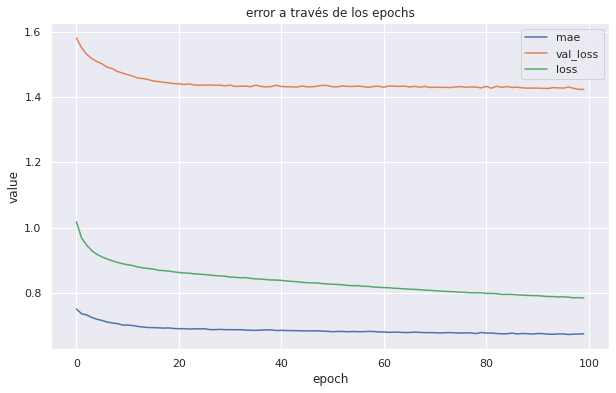

9/9 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.4195530197766815
MAE is : 0.861379942289295
RMSE is : 1.191449965284603
MAPE is : 41.464376124121635
Evaluation metric results:
MSE is : 1.339300549414751
MAE is : 0.8479995851095722
RMSE is : 1.157281534206241
MAPE is : 37.54227923967892
(637, 5, 4) (637, 1)
(271, 5, 4) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 23ms/step - loss: 0.9257 - mae: 0.7382 - val_loss: 1.4994 - val_mae: 0.7613
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9071 - mae: 0.7189 - val_loss: 1.4843 - val_mae: 0.7627
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8961 - mae: 0.7139 - val_loss: 1.4713 - val_mae: 0.7607
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8888 - mae: 0.7081 - val_loss: 1.4624 - val_mae: 0.7598
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8830 - mae: 0.7045 - val_loss:

Epoch 60/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7786 - mae: 0.6705 - val_loss: 1.3778 - val_mae: 0.7526
Epoch 61/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7759 - mae: 0.6716 - val_loss: 1.3715 - val_mae: 0.7507
Epoch 62/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7748 - mae: 0.6684 - val_loss: 1.3776 - val_mae: 0.7505
Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7730 - mae: 0.6709 - val_loss: 1.3749 - val_mae: 0.7503
Epoch 64/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7719 - mae: 0.6692 - val_loss: 1.3752 - val_mae: 0.7510
Epoch 65/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7703 - mae: 0.6684 - val_loss: 1.3759 - val_mae: 0.7506
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7688 - mae: 0.6682 - val_loss: 1.3726 - val_mae: 0.7473
Epoch 67/100
32/32 [==============================] - 0s 7ms/step - loss: 0.

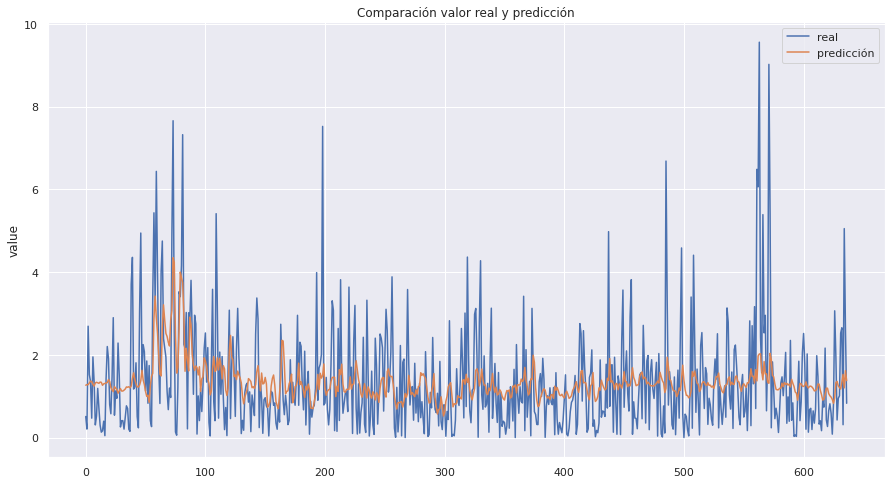

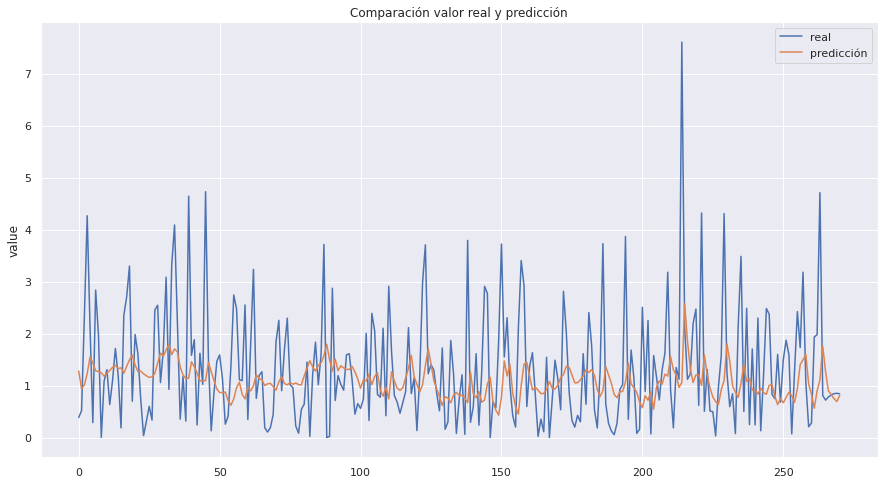

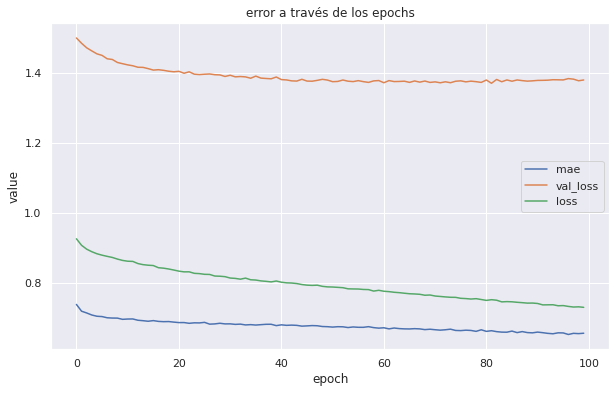

9/9 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.334650124015104
MAE is : 0.8385106465404859
RMSE is : 1.155270584761468
MAPE is : 40.477793342762595
Evaluation metric results:
MSE is : 1.3382031083825516
MAE is : 0.8605213626861513
RMSE is : 1.156807290944586
MAPE is : 38.993492895822264
(637, 5, 4) (637, 1)
(271, 5, 4) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 26ms/step - loss: 0.9123 - mae: 0.7252 - val_loss: 1.5073 - val_mae: 0.7764
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8937 - mae: 0.7090 - val_loss: 1.4838 - val_mae: 0.7736
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8837 - mae: 0.7087 - val_loss: 1.4699 - val_mae: 0.7698
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8737 - mae: 0.7009 - val_loss: 1.4587 - val_mae: 0.7690
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8670 - mae: 0.6976 - val_los

Epoch 60/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7548 - mae: 0.6580 - val_loss: 1.3891 - val_mae: 0.7529
Epoch 61/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7497 - mae: 0.6610 - val_loss: 1.3827 - val_mae: 0.7524
Epoch 62/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7469 - mae: 0.6546 - val_loss: 1.3915 - val_mae: 0.7509
Epoch 63/100
32/32 [==============================] - 0s 7ms/step - loss: 0.7452 - mae: 0.6587 - val_loss: 1.3900 - val_mae: 0.7525
Epoch 64/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7452 - mae: 0.6553 - val_loss: 1.3895 - val_mae: 0.7518
Epoch 65/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7432 - mae: 0.6559 - val_loss: 1.3917 - val_mae: 0.7522
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.7406 - mae: 0.6544 - val_loss: 1.3894 - val_mae: 0.7490
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.

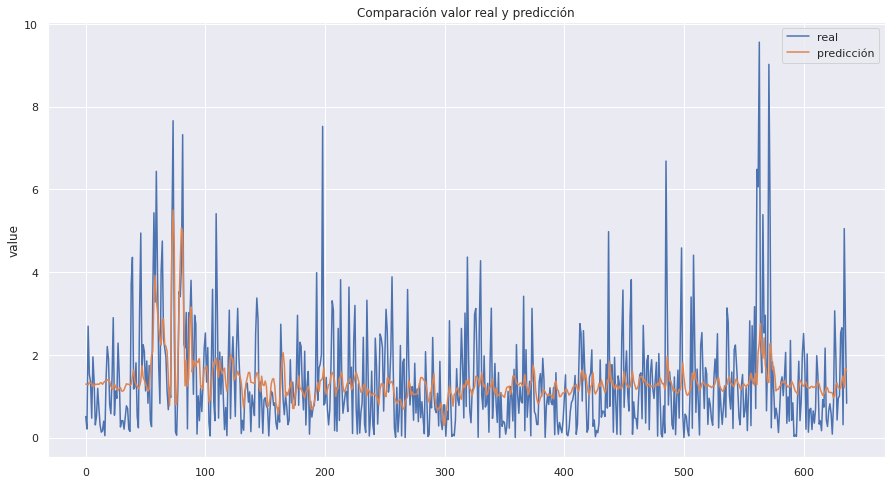

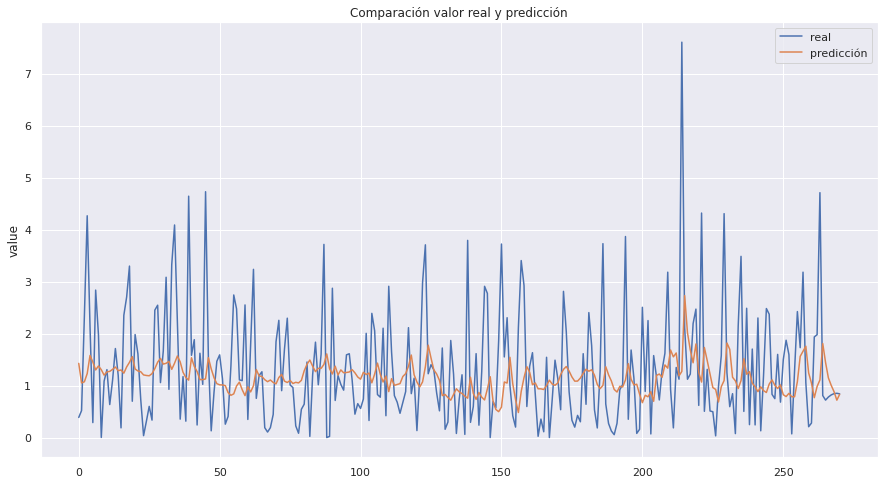

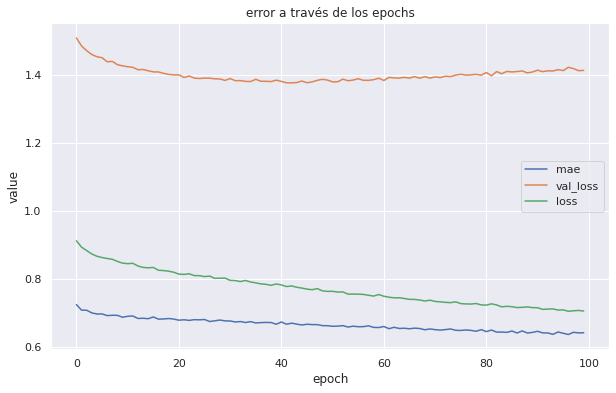

9/9 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.311580730088296
MAE is : 0.823957174585177
RMSE is : 1.1452426511828382
MAPE is : 39.77864644970652
Evaluation metric results:
MSE is : 1.3286806322548812
MAE is : 0.8673213845958693
RMSE is : 1.1526840990726301
MAPE is : 39.7784511777196
(637, 5, 4) (637, 1)
(271, 5, 4) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 26ms/step - loss: 0.9217 - mae: 0.7285 - val_loss: 1.4982 - val_mae: 0.7637
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8948 - mae: 0.7078 - val_loss: 1.4653 - val_mae: 0.7623
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8803 - mae: 0.7103 - val_loss: 1.4472 - val_mae: 0.7654
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8665 - mae: 0.6979 - val_loss: 1.4376 - val_mae: 0.7636
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8562 - mae: 0.6949 - val_loss:

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7369 - mae: 0.6504 - val_loss: 1.3822 - val_mae: 0.7435
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7308 - mae: 0.6511 - val_loss: 1.3729 - val_mae: 0.7474
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7263 - mae: 0.6441 - val_loss: 1.3854 - val_mae: 0.7407
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7256 - mae: 0.6507 - val_loss: 1.3847 - val_mae: 0.7486
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7219 - mae: 0.6451 - val_loss: 1.3817 - val_mae: 0.7421
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7232 - mae: 0.6470 - val_loss: 1.3856 - val_mae: 0.7456
Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7227 - mae: 0.6450 - val_loss: 1.3756 - val_mae: 0.7385
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0.

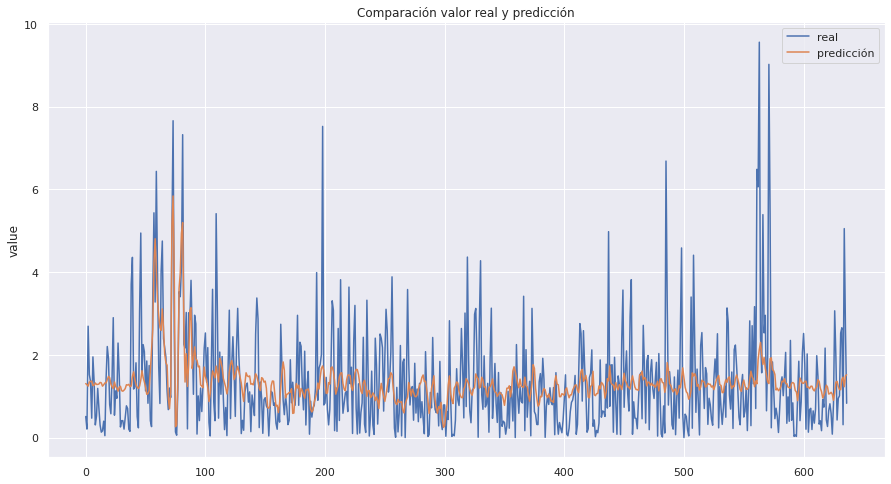

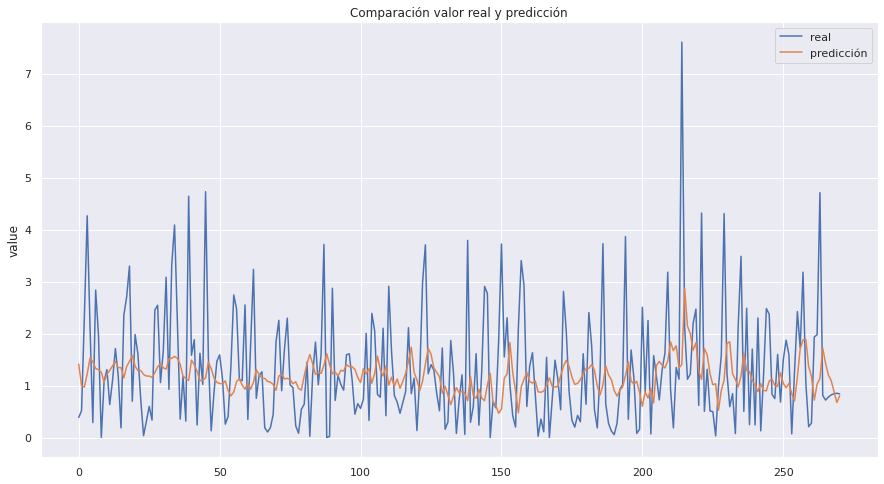

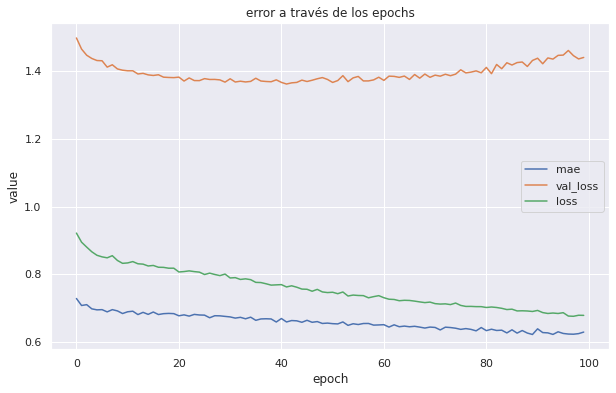

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2836082433955276
MAE is : 0.8049655324159548
RMSE is : 1.1329643610438624
MAPE is : 38.81765290995012
Evaluation metric results:
MSE is : 1.364367863217965
MAE is : 0.8908633230655386
RMSE is : 1.1680615836581414
MAPE is : 41.7577322942714
(637, 5, 4) (637, 1)
(271, 5, 4) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 32ms/step - loss: 0.9194 - mae: 0.7213 - val_loss: 1.4723 - val_mae: 0.7585
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8901 - mae: 0.7049 - val_loss: 1.4484 - val_mae: 0.7540
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8747 - mae: 0.7091 - val_loss: 1.4252 - val_mae: 0.7646
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8640 - mae: 0.6976 - val_loss: 1.4181 - val_mae: 0.7574
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8504 - mae: 0.6943 - val_

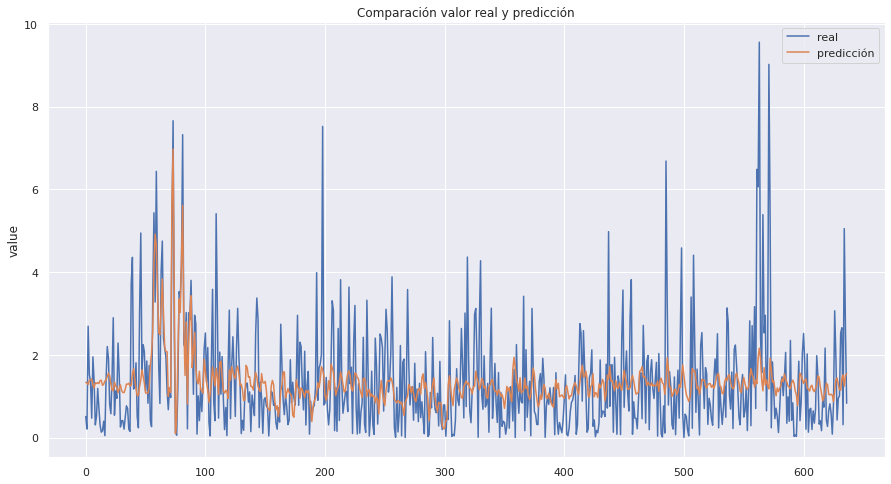

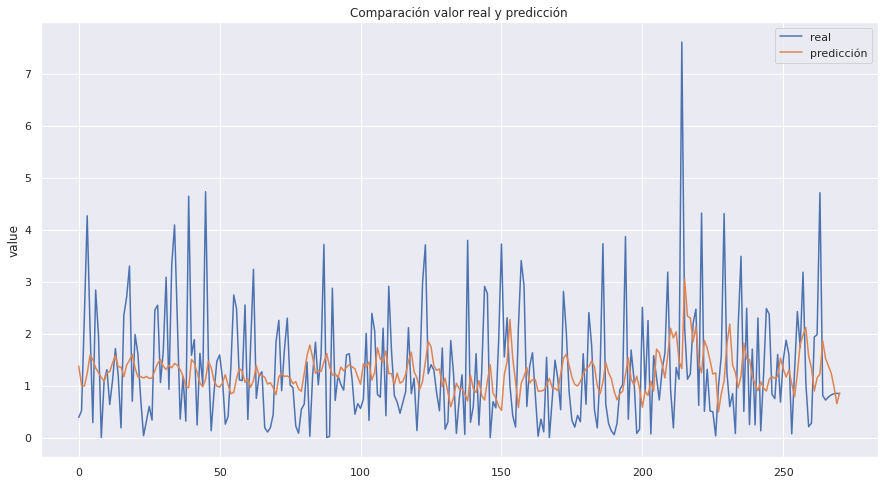

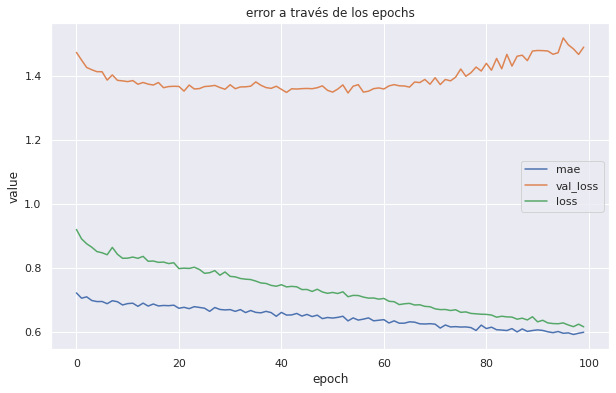

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.2150228946666963
MAE is : 0.7731590616727765
RMSE is : 1.1022807694352181
MAPE is : 37.59736614026711
Evaluation metric results:
MSE is : 1.4267144459389542
MAE is : 0.9112625558680292
RMSE is : 1.194451525152425
MAPE is : 43.63839082158341
(637, 5, 4) (637, 1)
(271, 5, 4) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 42ms/step - loss: 0.9355 - mae: 0.7276 - val_loss: 1.4816 - val_mae: 0.7561
Epoch 2/100
32/32 [==============================] - 1s 25ms/step - loss: 0.8955 - mae: 0.7099 - val_loss: 1.4401 - val_mae: 0.7486
Epoch 3/100
32/32 [==============================] - 1s 26ms/step - loss: 0.8706 - mae: 0.7058 - val_loss: 1.4064 - val_mae: 0.7673
Epoch 4/100
32/32 [==============================] - 1s 24ms/step - loss: 0.8650 - mae: 0.6984 - val_loss: 1.3991 - val_mae: 0.7573
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.8485 - mae: 0.6950 - val

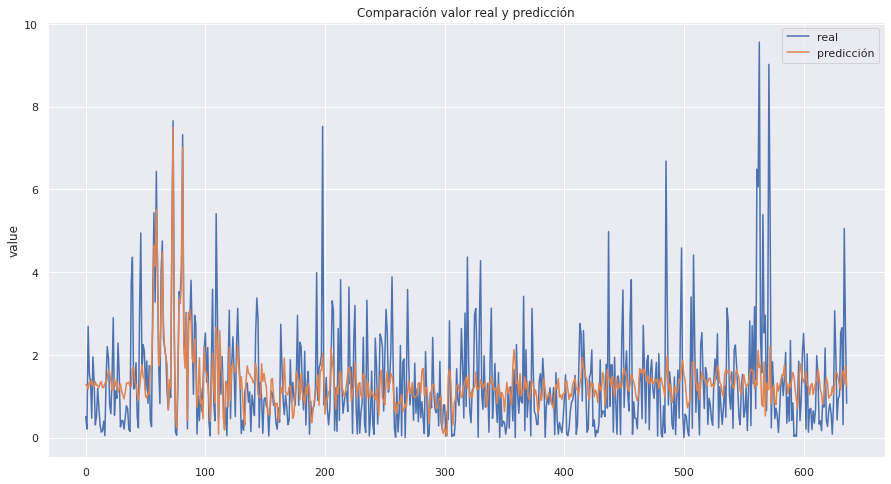

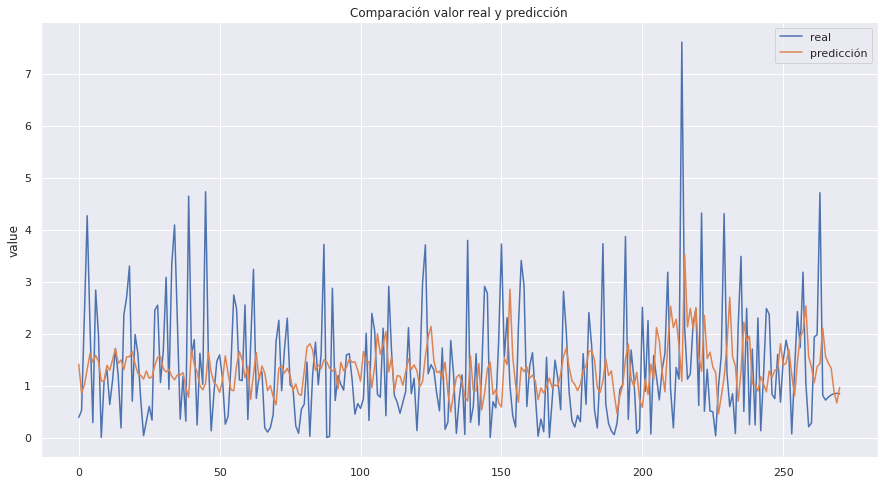

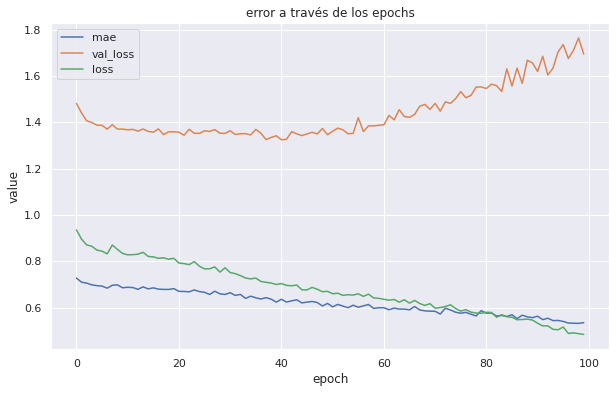

9/9 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 1.0958897464654707
MAE is : 0.7176804486123282
RMSE is : 1.0468475278021487
MAPE is : 34.84590603705009
Evaluation metric results:
MSE is : 1.7263054359798558
MAE is : 0.9826222871825236
RMSE is : 1.3138894306523117
MAPE is : 47.07092976280195
(634, 8, 4) (634, 1)
(268, 8, 4) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 0.9845 - mae: 0.7233 - val_loss: 1.4803 - val_mae: 0.8391
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9276 - mae: 0.7133 - val_loss: 1.4445 - val_mae: 0.7993
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9063 - mae: 0.7080 - val_loss: 1.4389 - val_mae: 0.7892
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8972 - mae: 0.7041 - val_loss: 1.4332 - val_mae: 0.7798
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8914 - mae: 0.7018 - val_lo

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8346 - mae: 0.6819 - val_loss: 1.4501 - val_mae: 0.7674
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8336 - mae: 0.6800 - val_loss: 1.4511 - val_mae: 0.7693
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8330 - mae: 0.6799 - val_loss: 1.4516 - val_mae: 0.7706
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8316 - mae: 0.6803 - val_loss: 1.4502 - val_mae: 0.7687
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8311 - mae: 0.6810 - val_loss: 1.4522 - val_mae: 0.7681
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8296 - mae: 0.6783 - val_loss: 1.4493 - val_mae: 0.7694
Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8289 - mae: 0.6785 - val_loss: 1.4527 - val_mae: 0.7684
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

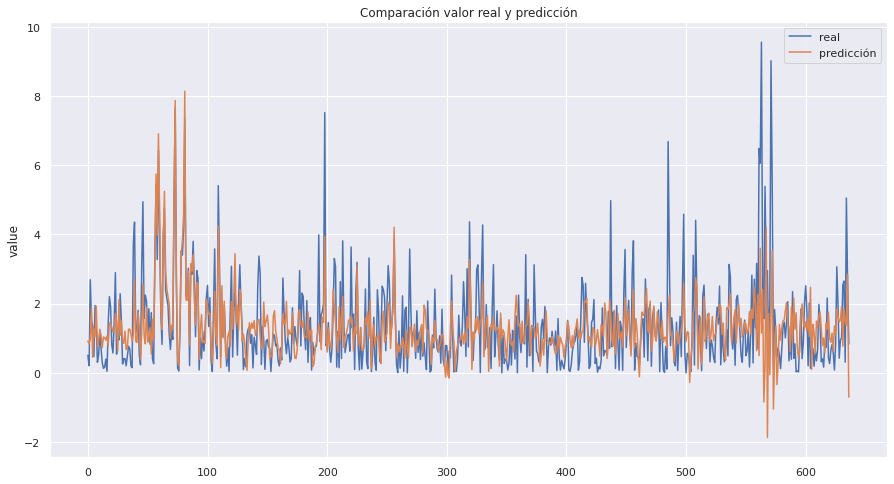

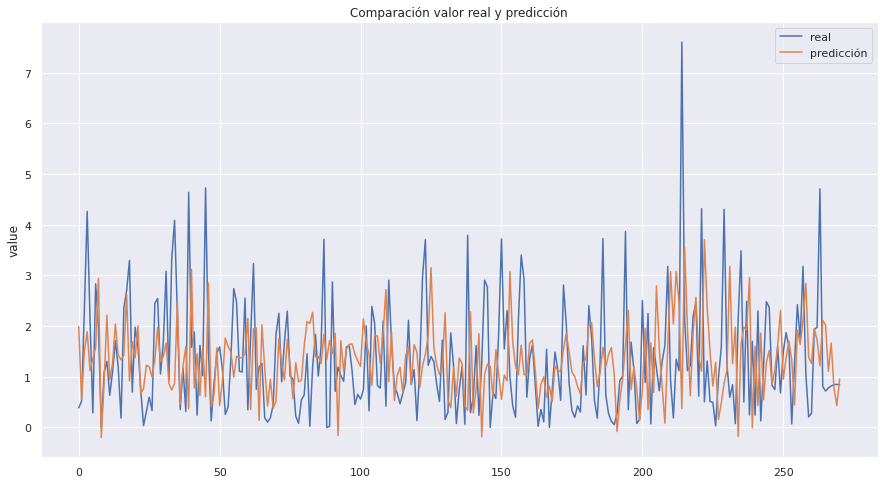

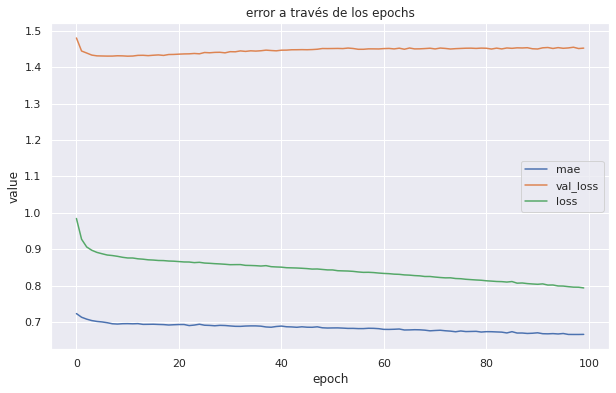

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4395970607163147
MAE is : 0.8560989809404564
RMSE is : 1.1998320968853577
MAPE is : 41.2116033430675
Evaluation metric results:
MSE is : 1.2776442722460846
MAE is : 0.849175452405052
RMSE is : 1.130329276028045
MAPE is : 39.15564588362505
(634, 8, 4) (634, 1)
(268, 8, 4) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9624 - mae: 0.7401 - val_loss: 1.5437 - val_mae: 0.7927
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9310 - mae: 0.7258 - val_loss: 1.5294 - val_mae: 0.7776
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9154 - mae: 0.7174 - val_loss: 1.5188 - val_mae: 0.7782
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9057 - mae: 0.7087 - val_loss: 1.5030 - val_mae: 0.7768
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8990 - mae: 0.7060 - val_loss:

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7975 - mae: 0.6678 - val_loss: 1.4351 - val_mae: 0.7672
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7961 - mae: 0.6654 - val_loss: 1.4376 - val_mae: 0.7707
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7967 - mae: 0.6676 - val_loss: 1.4387 - val_mae: 0.7727
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7937 - mae: 0.6677 - val_loss: 1.4363 - val_mae: 0.7695
Epoch 64/100
32/32 [==============================] - 0s 11ms/step - loss: 0.7908 - mae: 0.6662 - val_loss: 1.4398 - val_mae: 0.7704
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7900 - mae: 0.6635 - val_loss: 1.4351 - val_mae: 0.7705
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.7875 - mae: 0.6653 - val_loss: 1.4388 - val_mae: 0.7685
Epoch 67/100
32/32 [==============================] - 0s 9ms/step - loss: 0

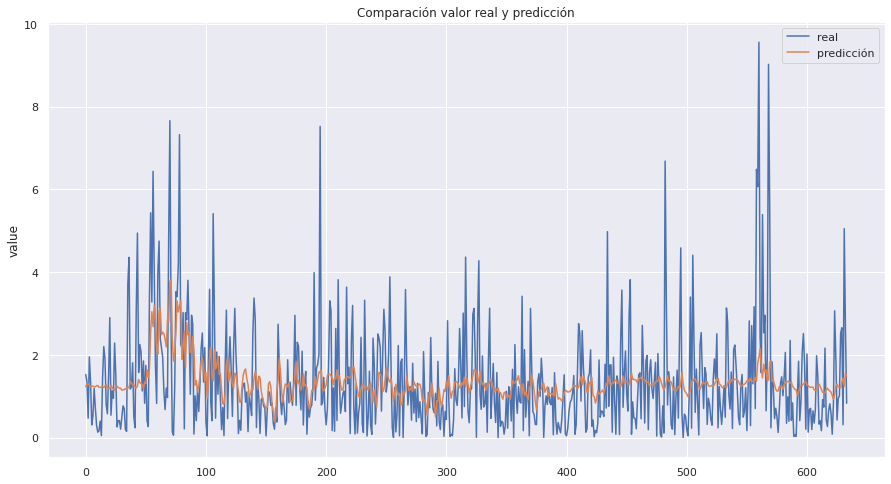

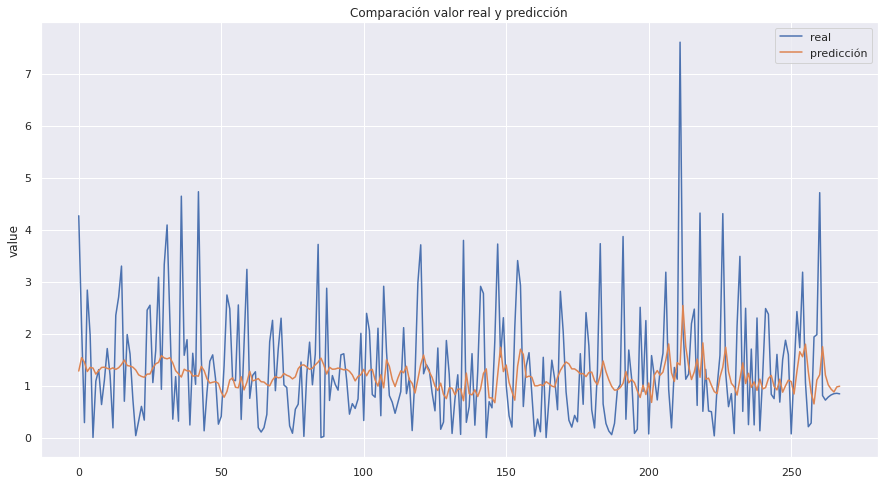

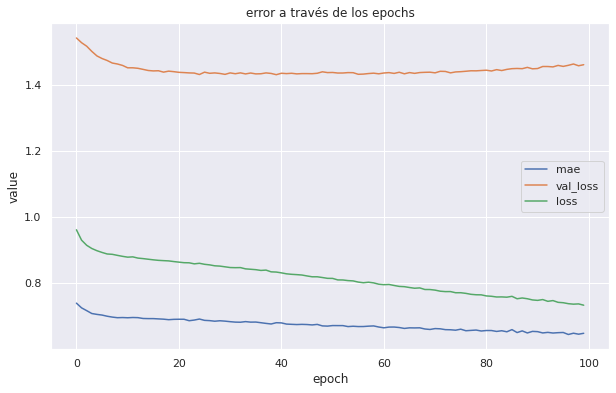

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3645047463947906
MAE is : 0.8384337143662061
RMSE is : 1.1681201763495015
MAPE is : 40.35198832639939
Evaluation metric results:
MSE is : 1.231530739493337
MAE is : 0.8443966433419519
RMSE is : 1.1097435467229972
MAPE is : 39.74279127025402
(634, 8, 4) (634, 1)
(268, 8, 4) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 31ms/step - loss: 0.9417 - mae: 0.7265 - val_loss: 1.4216 - val_mae: 0.7764
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8970 - mae: 0.7080 - val_loss: 1.4167 - val_mae: 0.7599
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8838 - mae: 0.6964 - val_loss: 1.4129 - val_mae: 0.7659
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8792 - mae: 0.6933 - val_loss: 1.4041 - val_mae: 0.7630
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8778 - mae: 0.6958 - val_lo

Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7220 - mae: 0.6455 - val_loss: 1.3655 - val_mae: 0.7494
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7141 - mae: 0.6390 - val_loss: 1.3692 - val_mae: 0.7542
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7156 - mae: 0.6407 - val_loss: 1.3735 - val_mae: 0.7556
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7115 - mae: 0.6440 - val_loss: 1.3719 - val_mae: 0.7536
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7081 - mae: 0.6357 - val_loss: 1.3783 - val_mae: 0.7557
Epoch 65/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7069 - mae: 0.6358 - val_loss: 1.3671 - val_mae: 0.7528
Epoch 66/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7116 - mae: 0.6391 - val_loss: 1.3763 - val_mae: 0.7526
Epoch 67/100
32/32 [==============================] - 0s 10ms/step - loss: 

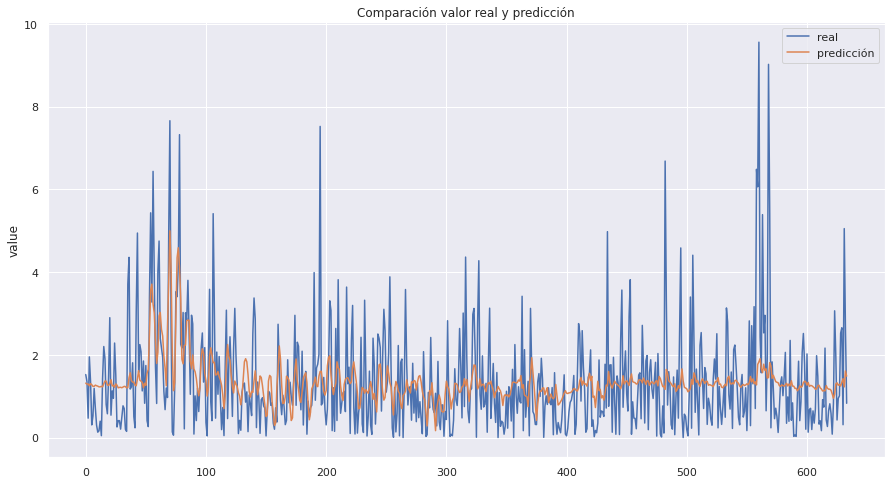

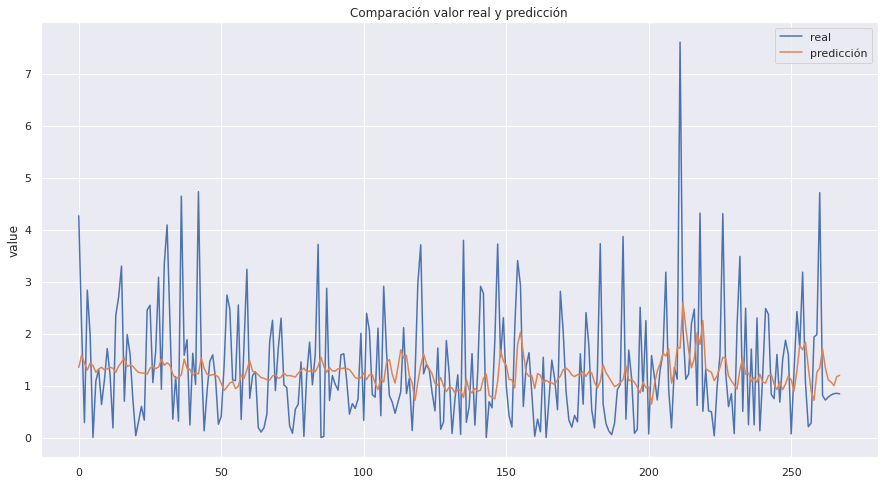

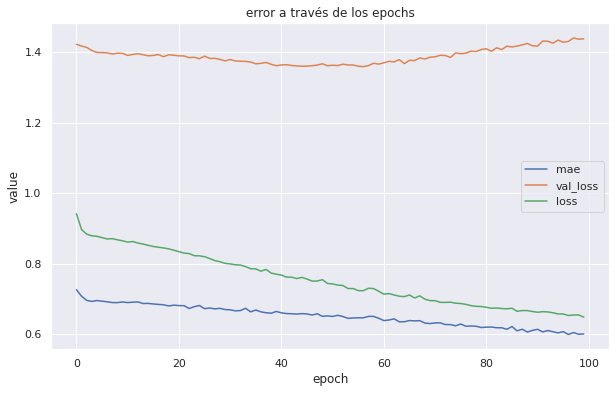

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2495339791464706
MAE is : 0.7860010470295306
RMSE is : 1.1178255584600267
MAPE is : 37.908794693075656
Evaluation metric results:
MSE is : 1.2727527456487526
MAE is : 0.8542678732357646
RMSE is : 1.128163439244843
MAPE is : 40.629602697369
(634, 8, 4) (634, 1)
(268, 8, 4) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9499 - mae: 0.7325 - val_loss: 1.5363 - val_mae: 0.7967
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9005 - mae: 0.7063 - val_loss: 1.5133 - val_mae: 0.7760
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8889 - mae: 0.6976 - val_loss: 1.4972 - val_mae: 0.7869
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8835 - mae: 0.6957 - val_loss: 1.4713 - val_mae: 0.7729
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8841 - mae: 0.7024 - val_

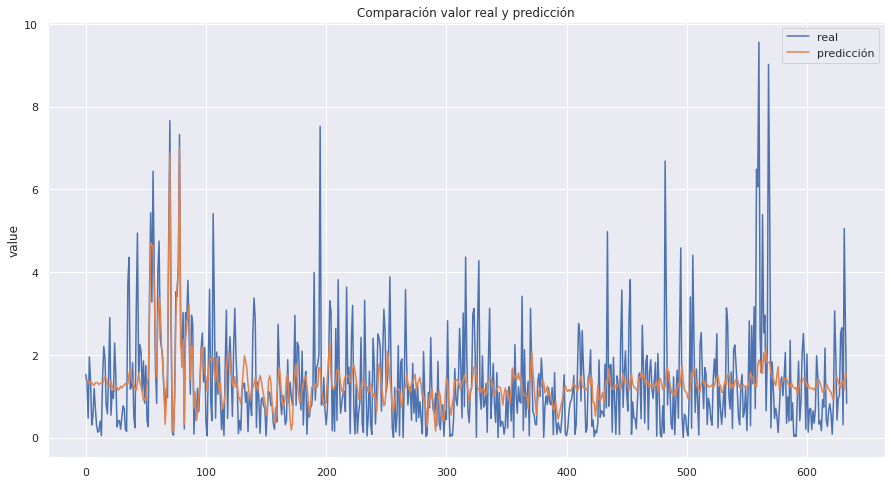

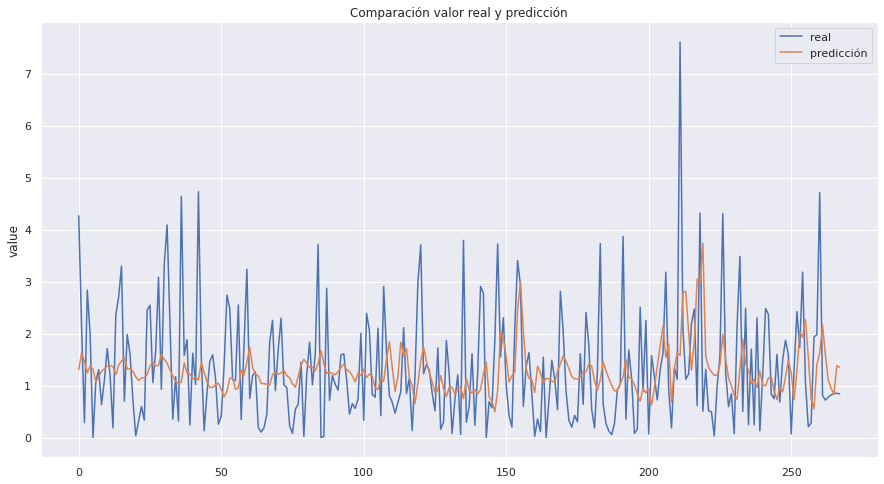

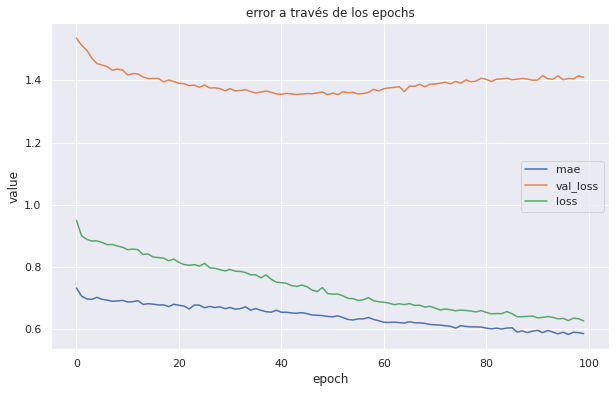

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.207110847638474
MAE is : 0.7654686349528238
RMSE is : 1.0986859640672917
MAPE is : 37.35368059305628
Evaluation metric results:
MSE is : 1.3070268664334046
MAE is : 0.8642476660707865
RMSE is : 1.1432527570198134
MAPE is : 40.40640307644714
(634, 8, 4) (634, 1)
(268, 8, 4) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 43ms/step - loss: 0.9526 - mae: 0.7277 - val_loss: 1.4588 - val_mae: 0.7799
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.8943 - mae: 0.7045 - val_loss: 1.4540 - val_mae: 0.7644
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8813 - mae: 0.6956 - val_loss: 1.4504 - val_mae: 0.7751
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8732 - mae: 0.6931 - val_loss: 1.4229 - val_mae: 0.7589
Epoch 5/100
32/32 [==============================] - 1s 21ms/step - loss: 0.8725 - mae: 0.6991 - val

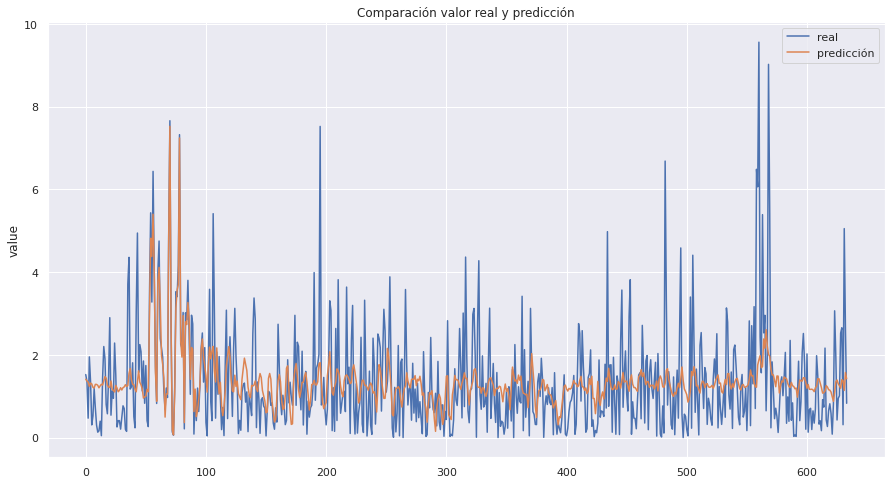

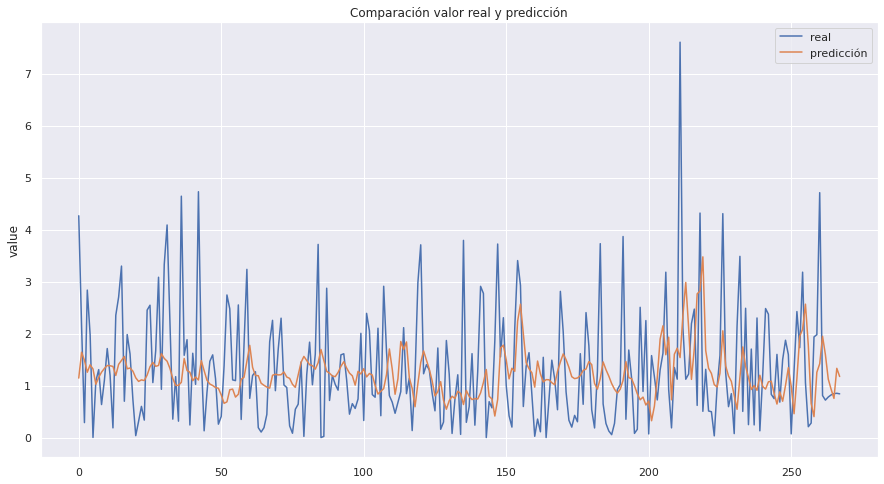

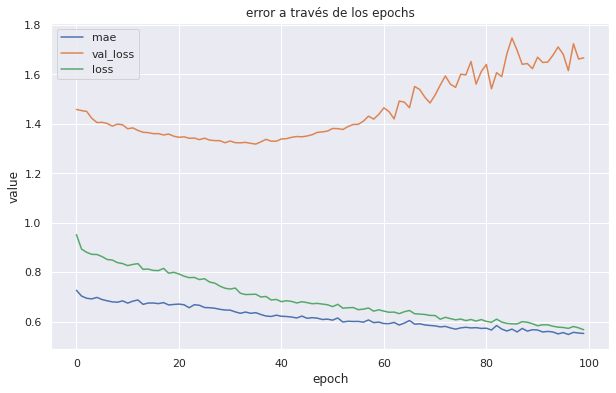

9/9 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.2104206283556336
MAE is : 0.7624904229842208
RMSE is : 1.1001911780938955
MAPE is : 37.88260365166281
Evaluation metric results:
MSE is : 1.4672108473923373
MAE is : 0.9188452732823612
RMSE is : 1.2112847920255325
MAPE is : 41.979634501157626
(634, 8, 4) (634, 1)
(268, 8, 4) (268, 1)
Epoch 1/100
32/32 [==============================] - 5s 64ms/step - loss: 1.0120 - mae: 0.7397 - val_loss: 1.4700 - val_mae: 0.7857
Epoch 2/100
32/32 [==============================] - 1s 39ms/step - loss: 0.8975 - mae: 0.7094 - val_loss: 1.4586 - val_mae: 0.7602
Epoch 3/100
32/32 [==============================] - 1s 41ms/step - loss: 0.8788 - mae: 0.6956 - val_loss: 1.4391 - val_mae: 0.7657
Epoch 4/100
32/32 [==============================] - 1s 43ms/step - loss: 0.8697 - mae: 0.6923 - val_loss: 1.4123 - val_mae: 0.7543
Epoch 5/100
32/32 [==============================] - 1s 41ms/step - loss: 0.8658 - mae: 0.6965 - v

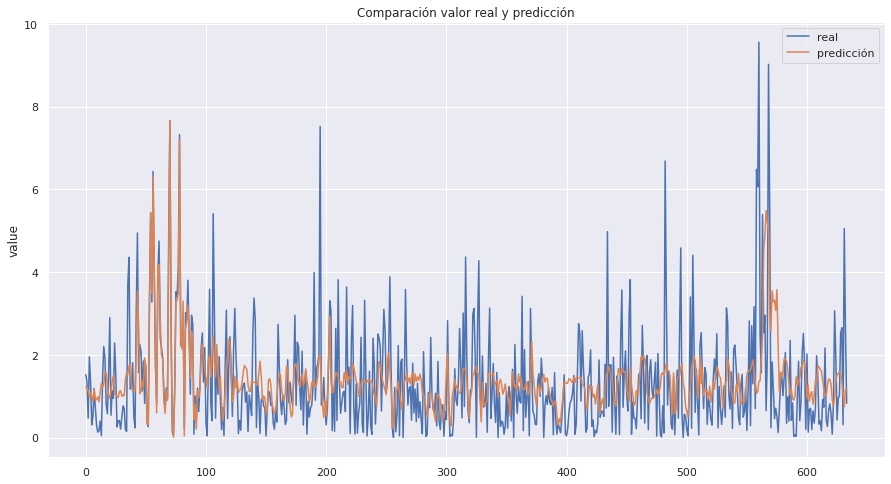

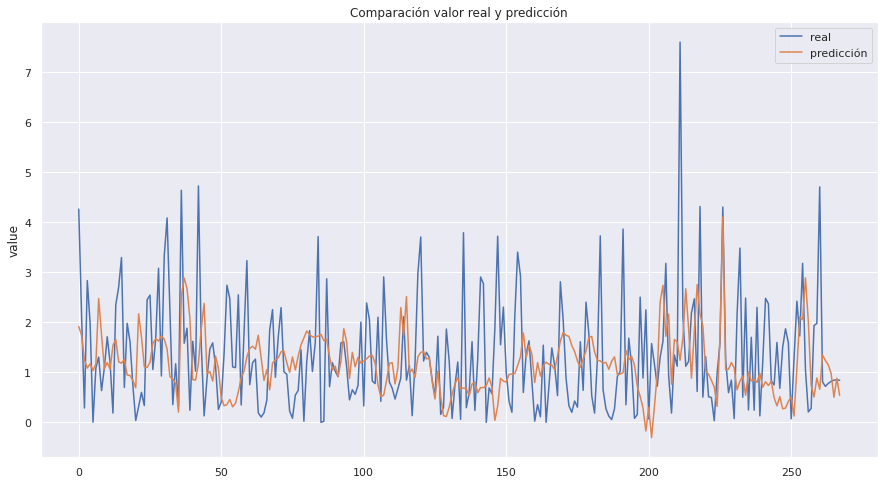

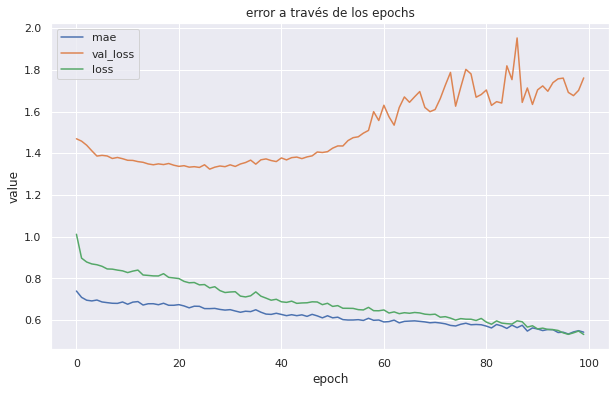

9/9 [==============================] - 0s 15ms/step
Evaluation metric results:
MSE is : 1.1667494185360592
MAE is : 0.7447248527632285
RMSE is : 1.0801617557273815
MAPE is : 37.61670394050986
Evaluation metric results:
MSE is : 1.5448689391791843
MAE is : 0.9396431295205959
RMSE is : 1.2429275679536536
MAPE is : 43.55916037268335
(632, 10, 4) (632, 1)
(266, 10, 4) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9182 - mae: 0.7276 - val_loss: 1.4316 - val_mae: 0.7554
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9049 - mae: 0.7185 - val_loss: 1.4189 - val_mae: 0.7597
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8983 - mae: 0.7132 - val_loss: 1.4184 - val_mae: 0.7580
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8938 - mae: 0.7082 - val_loss: 1.4154 - val_mae: 0.7633
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8884 - mae: 0.7037 -

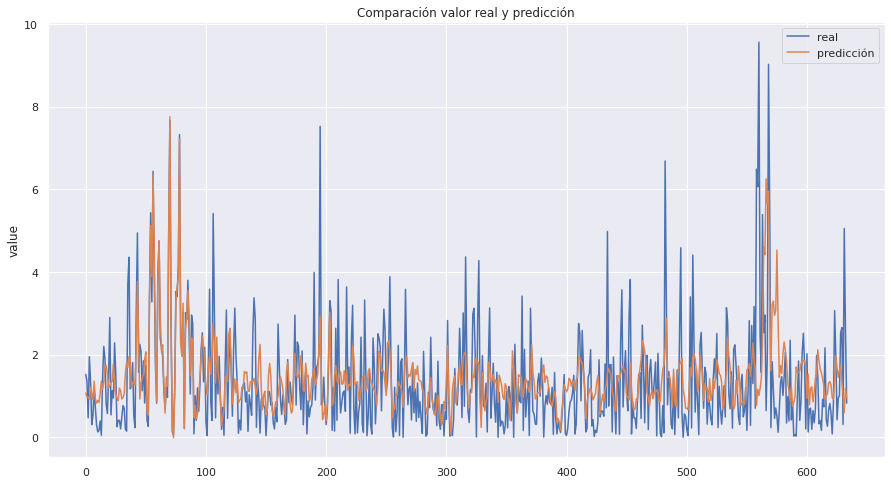

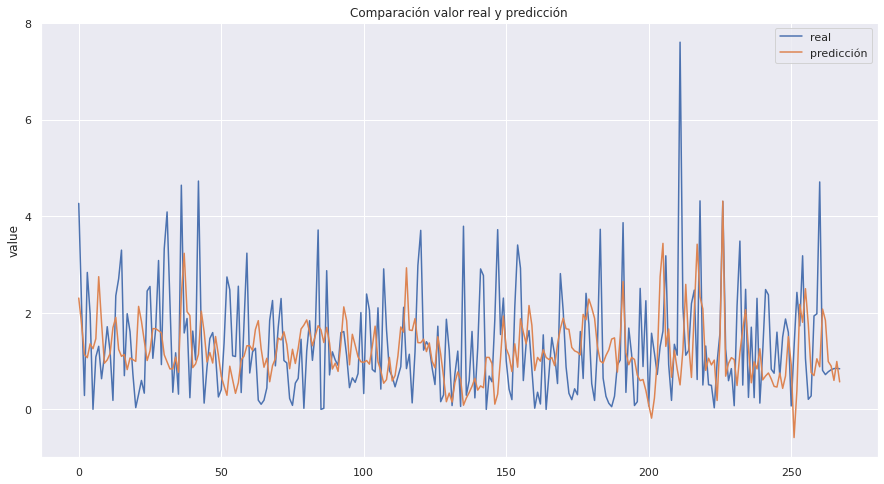

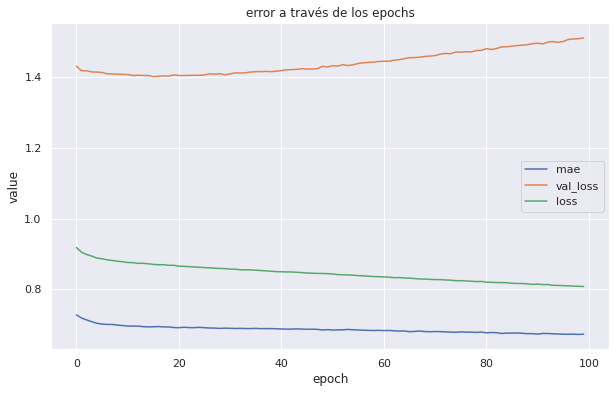

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4756050659539428
MAE is : 0.8659118292345961
RMSE is : 1.2147448563191954
MAPE is : 41.53887863688588
Evaluation metric results:
MSE is : 1.317936071308542
MAE is : 0.8603351436129736
RMSE is : 1.1480139682549781
MAPE is : 39.762367380412094
(632, 10, 4) (632, 1)
(266, 10, 4) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.9940 - mae: 0.7479 - val_loss: 1.4877 - val_mae: 0.7922
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9329 - mae: 0.7277 - val_loss: 1.4604 - val_mae: 0.7793
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9110 - mae: 0.7157 - val_loss: 1.4442 - val_mae: 0.7680
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8996 - mae: 0.7045 - val_loss: 1.4359 - val_mae: 0.7685
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8890 - mae: 0.6993 - 

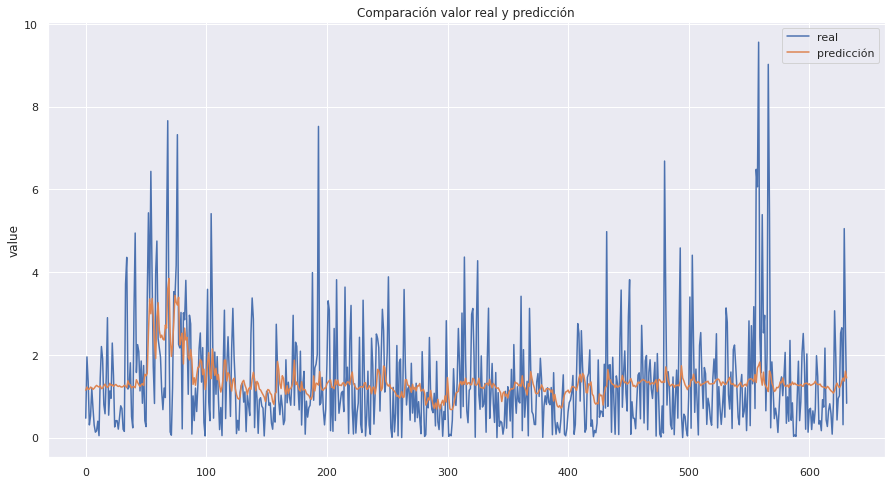

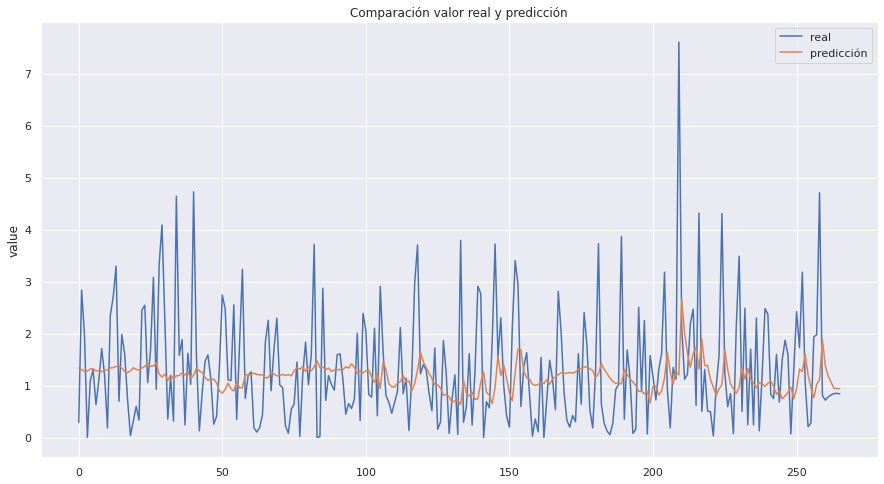

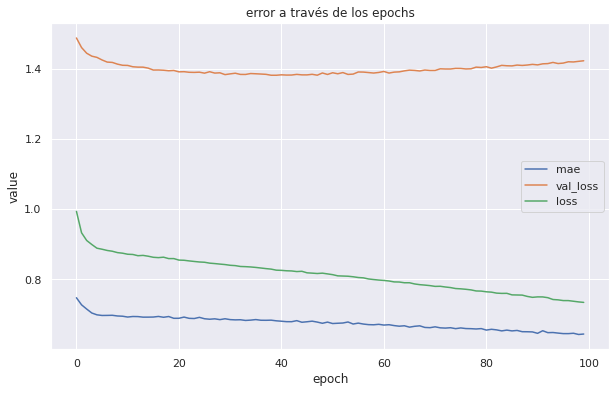

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3531115453359677
MAE is : 0.8276222882004098
RMSE is : 1.1632332291230196
MAPE is : 39.650367388931244
Evaluation metric results:
MSE is : 1.25505242121644
MAE is : 0.8595470352998624
RMSE is : 1.1202912216100063
MAPE is : 41.47734057561112
(632, 10, 4) (632, 1)
(266, 10, 4) (266, 1)
Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 0.9601 - mae: 0.7311 - val_loss: 1.5259 - val_mae: 0.7756
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9100 - mae: 0.7196 - val_loss: 1.4881 - val_mae: 0.7756
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8981 - mae: 0.7093 - val_loss: 1.4701 - val_mae: 0.7698
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8976 - mae: 0.7034 - val_loss: 1.4576 - val_mae: 0.7754
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8840 - mae: 0.7000 - val_l

Epoch 60/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7267 - mae: 0.6435 - val_loss: 1.3629 - val_mae: 0.7575
Epoch 61/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7268 - mae: 0.6431 - val_loss: 1.3660 - val_mae: 0.7578
Epoch 62/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7272 - mae: 0.6421 - val_loss: 1.3570 - val_mae: 0.7550
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7183 - mae: 0.6366 - val_loss: 1.3601 - val_mae: 0.7558
Epoch 64/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7170 - mae: 0.6370 - val_loss: 1.3614 - val_mae: 0.7543
Epoch 65/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7152 - mae: 0.6359 - val_loss: 1.3663 - val_mae: 0.7556
Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7162 - mae: 0.6318 - val_loss: 1.3675 - val_mae: 0.7518
Epoch 67/100
32/32 [==============================] - 0s 10ms/step - los

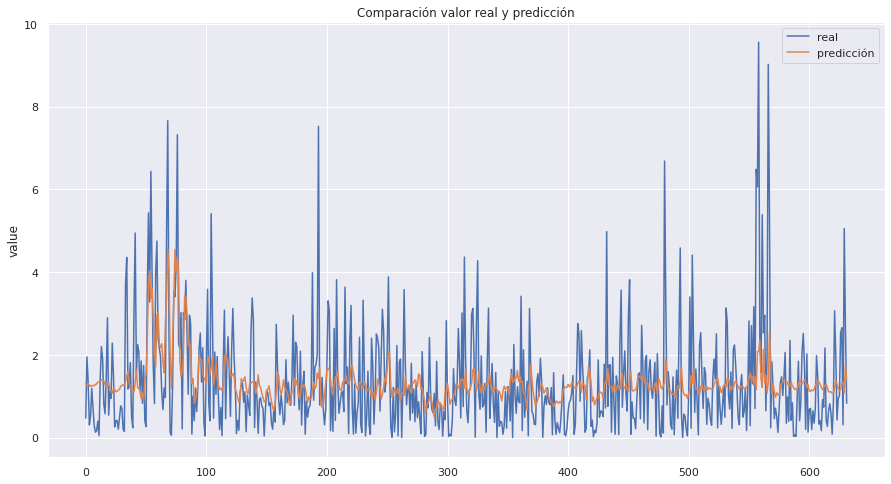

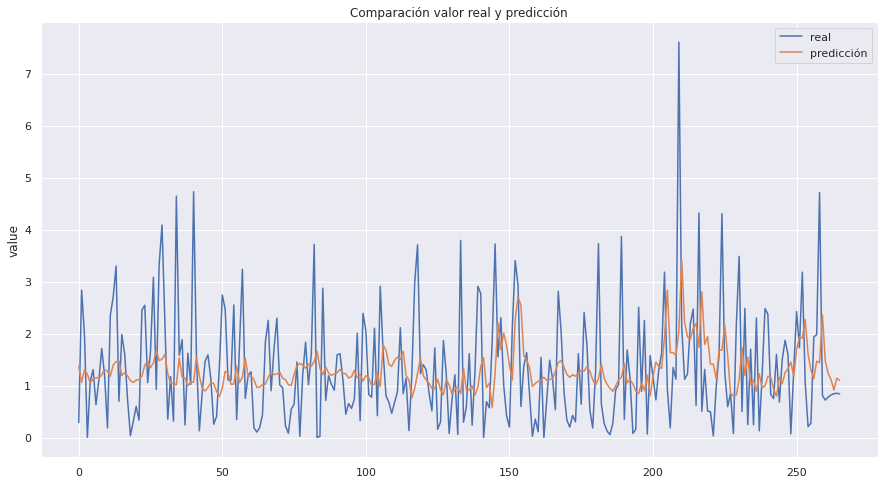

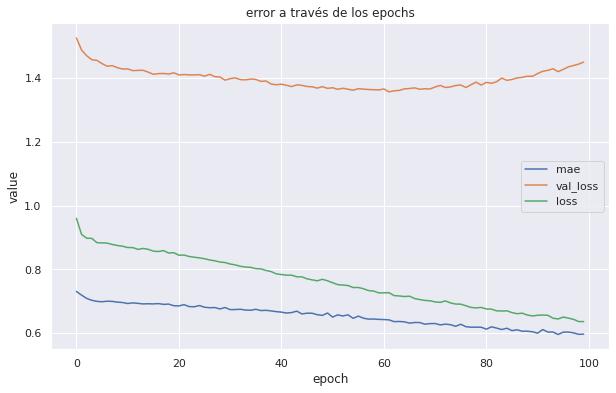

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.234079505153482
MAE is : 0.7788945076845284
RMSE is : 1.1108913111342091
MAPE is : 37.59934127043561
Evaluation metric results:
MSE is : 1.4000214069342027
MAE is : 0.9215872781469708
RMSE is : 1.1832250026661044
MAPE is : 45.50381035497716
(632, 10, 4) (632, 1)
(266, 10, 4) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 31ms/step - loss: 0.9280 - mae: 0.7133 - val_loss: 1.4544 - val_mae: 0.7598
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9045 - mae: 0.7155 - val_loss: 1.4305 - val_mae: 0.7721
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8922 - mae: 0.7080 - val_loss: 1.4212 - val_mae: 0.7716
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9067 - mae: 0.7038 - val_loss: 1.4252 - val_mae: 0.7713
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.8809 - mae: 0.7010 - v

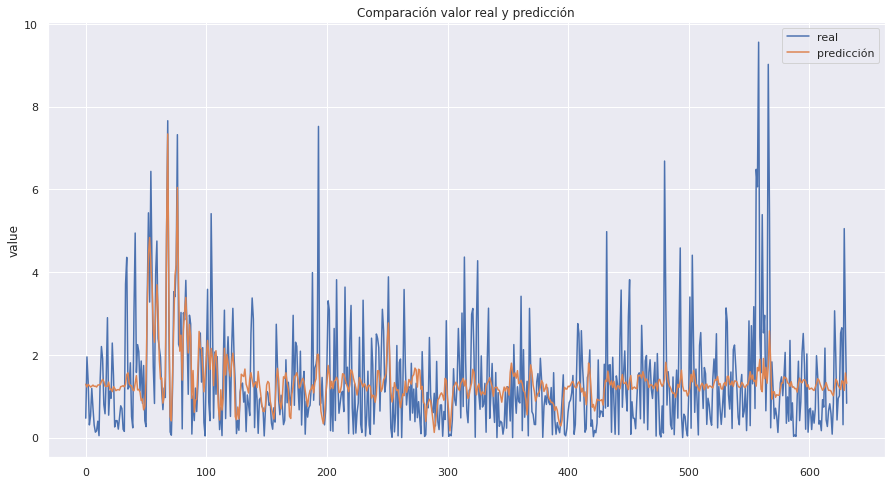

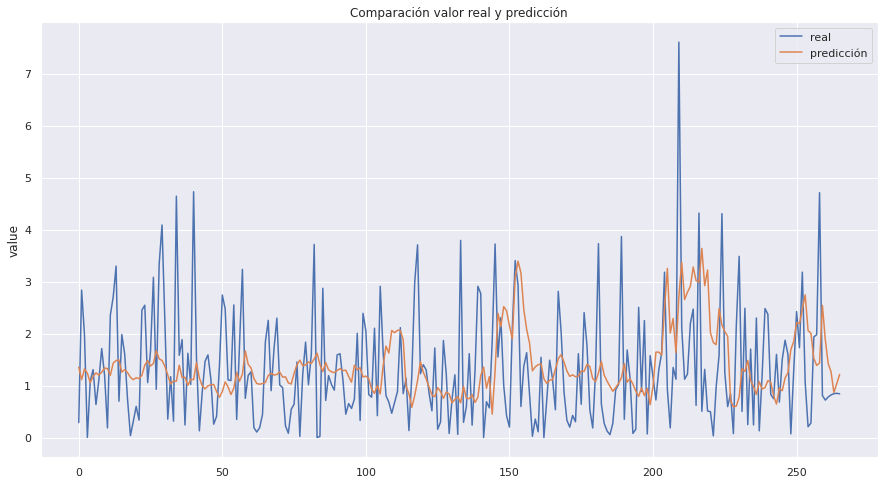

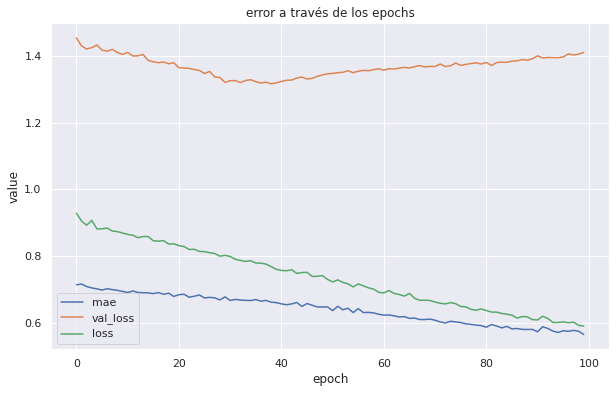

9/9 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.1644979143497736
MAE is : 0.75309258336129
RMSE is : 1.0791190454948767
MAPE is : 36.88149887431333
Evaluation metric results:
MSE is : 1.4273779071747612
MAE is : 0.9200788140792964
RMSE is : 1.1947292191851513
MAPE is : 45.400461263499
(632, 10, 4) (632, 1)
(266, 10, 4) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 39ms/step - loss: 0.9504 - mae: 0.7228 - val_loss: 1.4648 - val_mae: 0.7537
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9103 - mae: 0.7153 - val_loss: 1.4327 - val_mae: 0.7649
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8885 - mae: 0.7063 - val_loss: 1.4202 - val_mae: 0.7744
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.9155 - mae: 0.7052 - val_loss: 1.4272 - val_mae: 0.7646
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8791 - mae: 0.7004 - val_

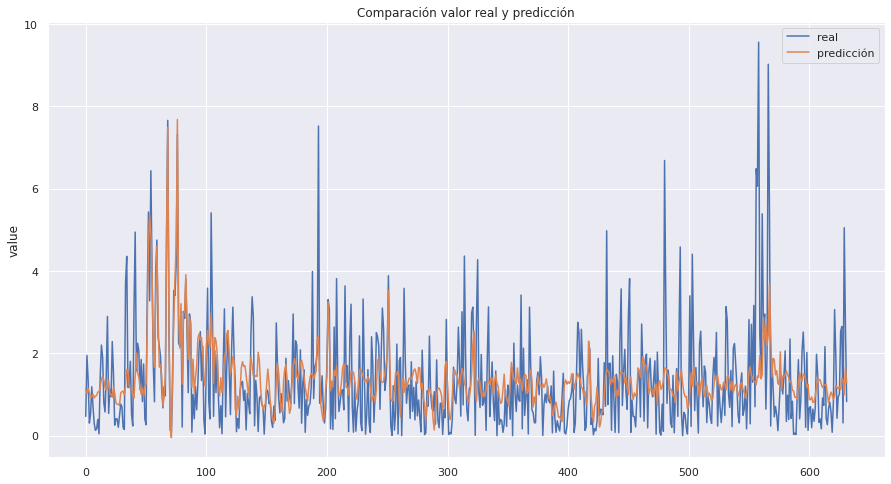

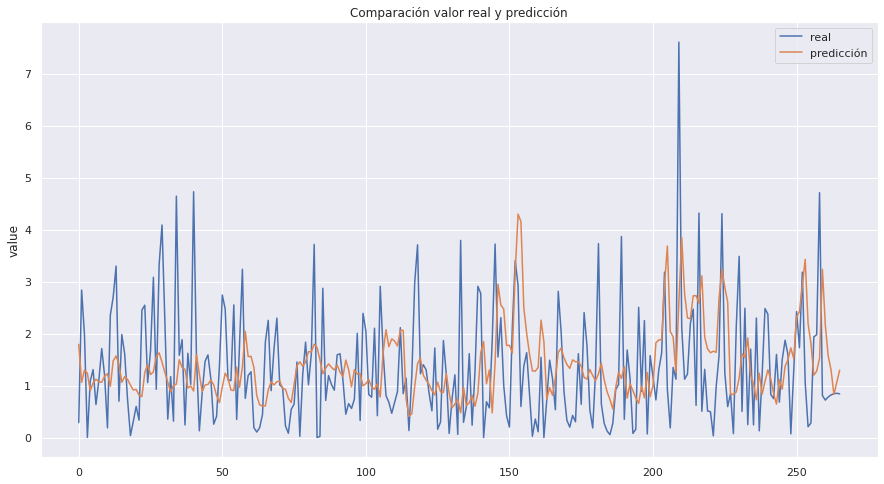

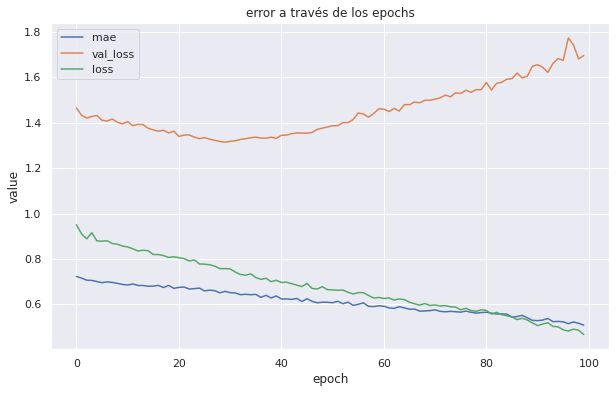

9/9 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 1.0845000303144299
MAE is : 0.7022278489701959
RMSE is : 1.0413933120173329
MAPE is : 33.4145657909016
Evaluation metric results:
MSE is : 1.8180854300179892
MAE is : 1.0536019041733238
RMSE is : 1.3483639827650356
MAPE is : 53.61120418499845
(632, 10, 4) (632, 1)
(266, 10, 4) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 76ms/step - loss: 0.9578 - mae: 0.7269 - val_loss: 1.4707 - val_mae: 0.7561
Epoch 2/100
32/32 [==============================] - 1s 40ms/step - loss: 0.9057 - mae: 0.7172 - val_loss: 1.4170 - val_mae: 0.7501
Epoch 3/100
32/32 [==============================] - 1s 38ms/step - loss: 0.8810 - mae: 0.7038 - val_loss: 1.4055 - val_mae: 0.7629
Epoch 4/100
32/32 [==============================] - 1s 39ms/step - loss: 0.9036 - mae: 0.7044 - val_loss: 1.4149 - val_mae: 0.7548
Epoch 5/100
32/32 [==============================] - 1s 39ms/step - loss: 0.8681 - mae: 0.6989 - v

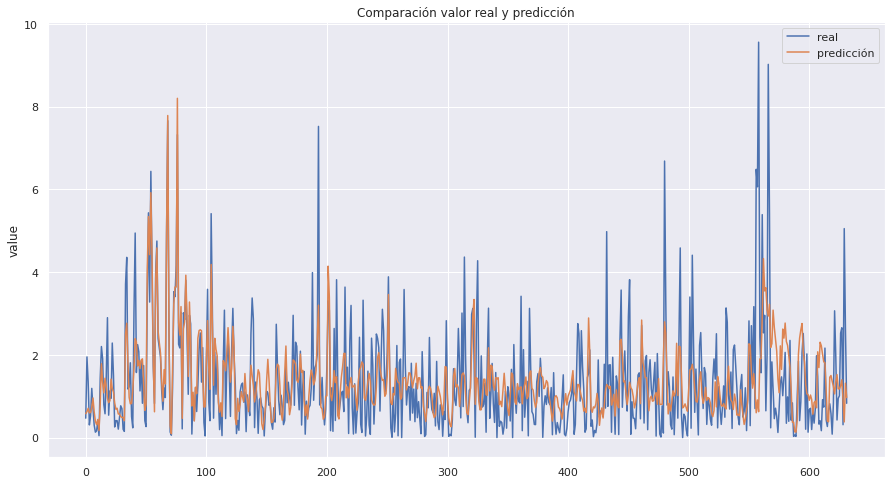

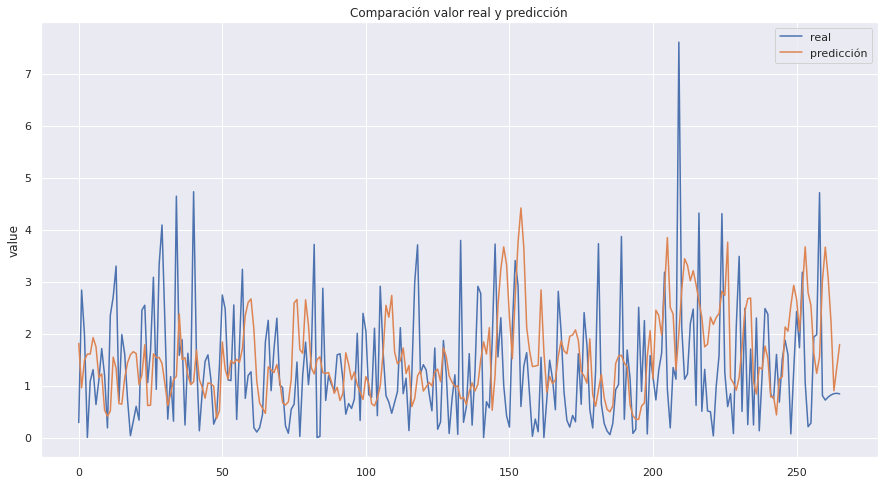

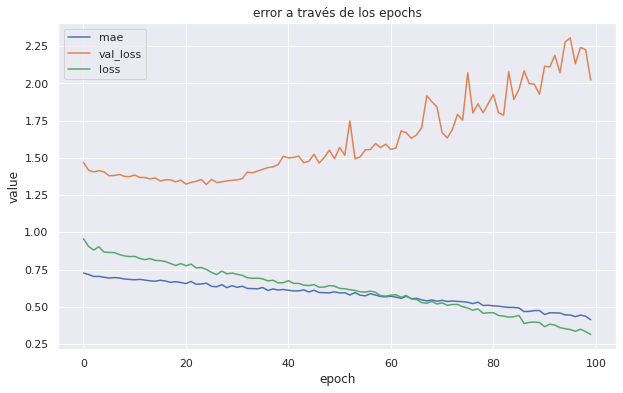

9/9 [==============================] - 0s 17ms/step
Evaluation metric results:
MSE is : 0.9996177518685736
MAE is : 0.6342600494724634
RMSE is : 0.999808857666591
MAPE is : 30.30826824635741
Evaluation metric results:
MSE is : 2.2547352353394987
MAE is : 1.145856648852024
RMSE is : 1.5015775821913095
MAPE is : 54.36855448730441
(627, 15, 4) (627, 1)
(261, 15, 4) (261, 1)
Epoch 1/100
32/32 [==============================] - 3s 30ms/step - loss: 0.9811 - mae: 0.7615 - val_loss: 1.5101 - val_mae: 0.7472
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9371 - mae: 0.7343 - val_loss: 1.4762 - val_mae: 0.7518
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9191 - mae: 0.7248 - val_loss: 1.4565 - val_mae: 0.7579
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9100 - mae: 0.7180 - val_loss: 1.4479 - val_mae: 0.7612
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9038 - mae: 0.7122 - v

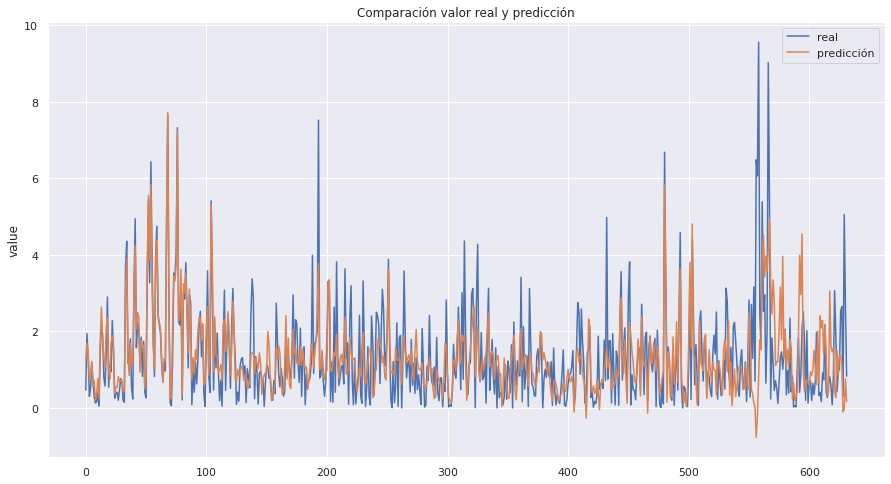

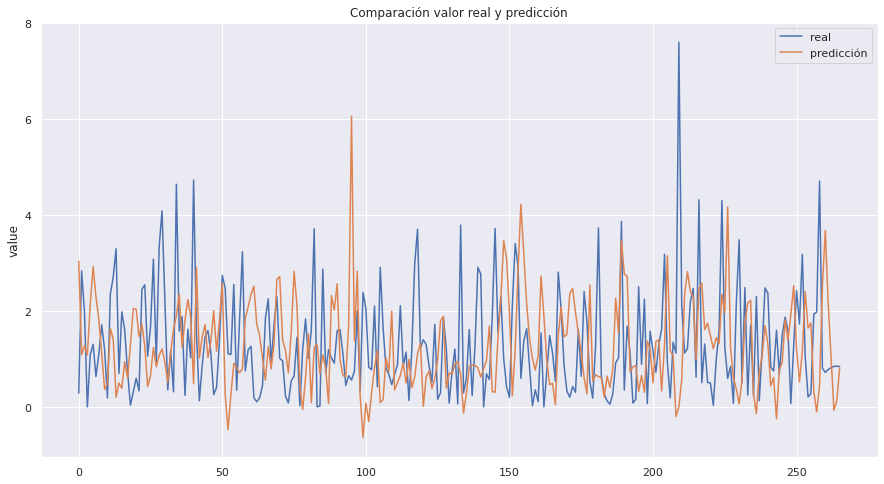

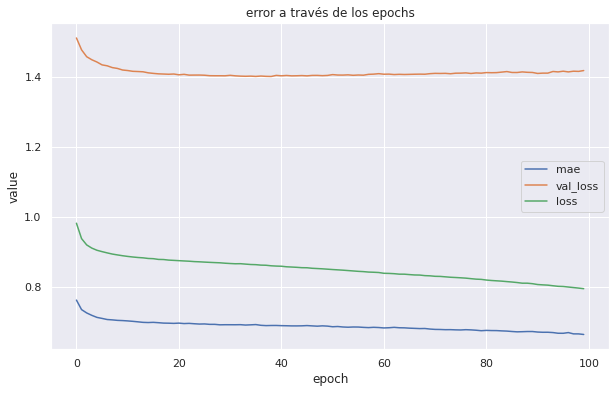

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.4289122288053528
MAE is : 0.8554458552138181
RMSE is : 1.195371167799087
MAPE is : 41.25524608305351
Evaluation metric results:
MSE is : 1.262169962499661
MAE is : 0.8348359903803874
RMSE is : 1.1234633783526995
MAPE is : 39.11492166724931
(627, 15, 4) (627, 1)
(261, 15, 4) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 39ms/step - loss: 1.0503 - mae: 0.7553 - val_loss: 1.6647 - val_mae: 0.8399
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9701 - mae: 0.7326 - val_loss: 1.6350 - val_mae: 0.8183
Epoch 3/100
32/32 [==============================] - 0s 16ms/step - loss: 0.9433 - mae: 0.7274 - val_loss: 1.6094 - val_mae: 0.8123
Epoch 4/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9267 - mae: 0.7199 - val_loss: 1.5897 - val_mae: 0.8062
Epoch 5/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9135 - mae: 0.7113 - va

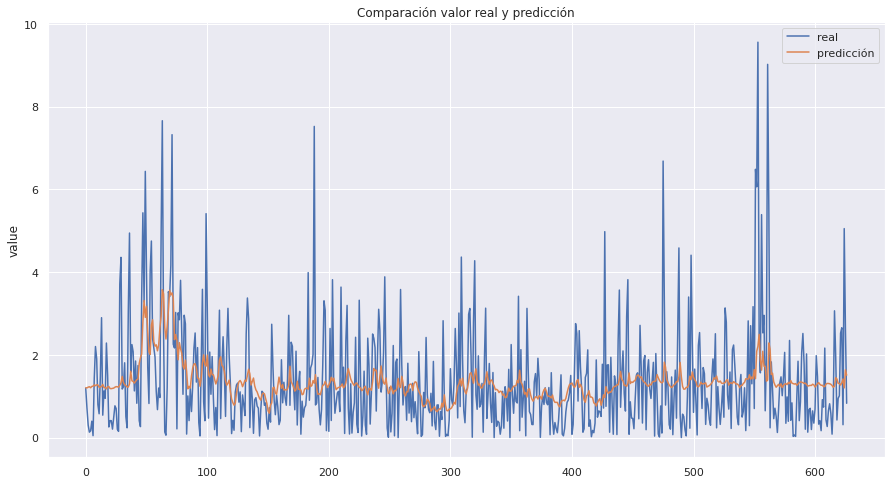

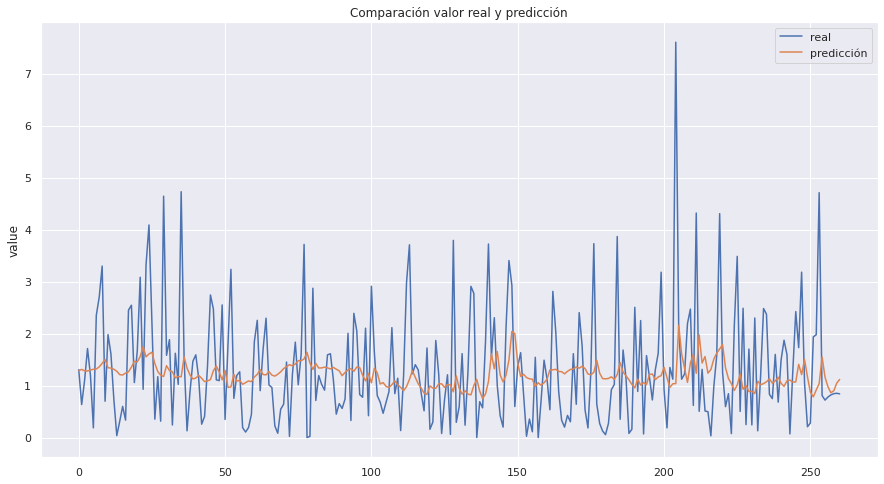

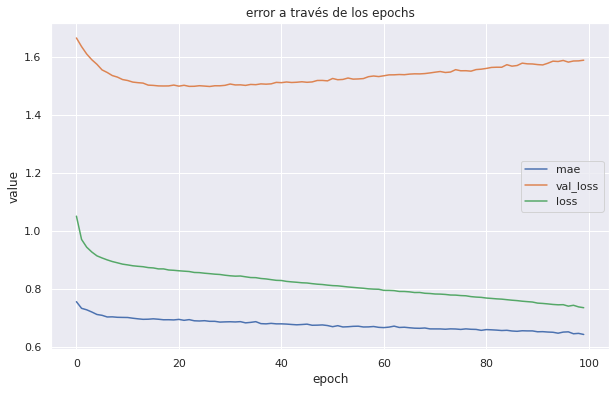

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4058641355711694
MAE is : 0.840261939458824
RMSE is : 1.1856914166726389
MAPE is : 40.0751304434601
Evaluation metric results:
MSE is : 1.294580762165255
MAE is : 0.847113023680136
RMSE is : 1.137796450234072
MAPE is : 40.1945869157818
(627, 15, 4) (627, 1)
(261, 15, 4) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.9579 - mae: 0.7460 - val_loss: 1.5872 - val_mae: 0.8101
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9154 - mae: 0.7036 - val_loss: 1.5520 - val_mae: 0.7939
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9021 - mae: 0.7096 - val_loss: 1.5285 - val_mae: 0.7942
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.8962 - mae: 0.7046 - val_loss: 1.5082 - val_mae: 0.7924
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.8896 - mae: 0.6981 - val_lo

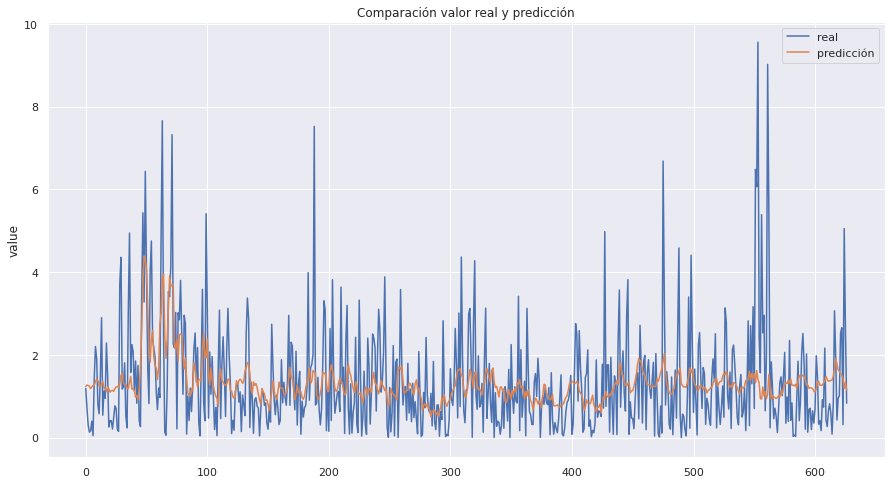

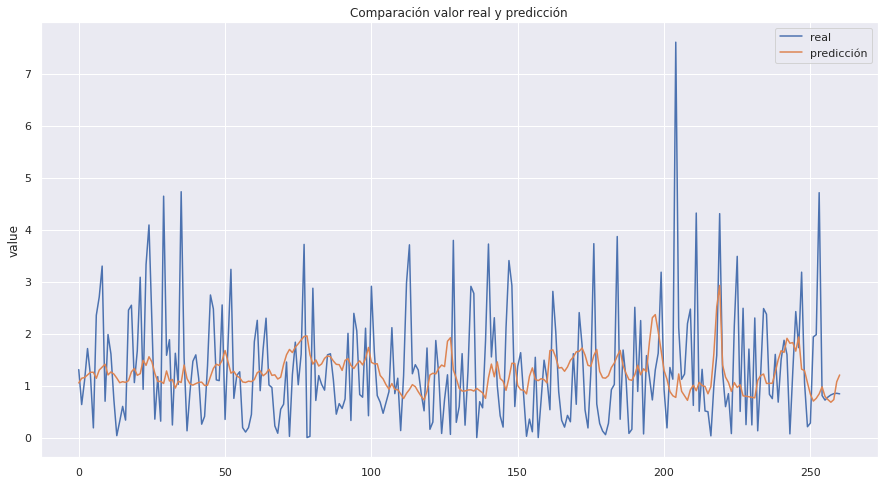

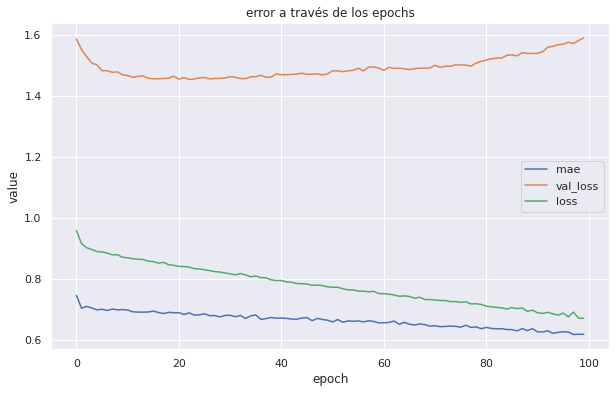

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.3170046706151823
MAE is : 0.8230211149612863
RMSE is : 1.1476082391718798
MAPE is : 40.195841569379645
Evaluation metric results:
MSE is : 1.3998745294845918
MAE is : 0.8846614860146192
RMSE is : 1.1831629344619412
MAPE is : 41.2275079762885
(627, 15, 4) (627, 1)
(261, 15, 4) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 43ms/step - loss: 0.9391 - mae: 0.7338 - val_loss: 1.4863 - val_mae: 0.7998
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9089 - mae: 0.7003 - val_loss: 1.4620 - val_mae: 0.7646
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 0.8916 - mae: 0.7053 - val_loss: 1.4444 - val_mae: 0.7735
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8865 - mae: 0.7000 - val_loss: 1.4422 - val_mae: 0.7790
Epoch 5/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8775 - mae: 0.6931 - 

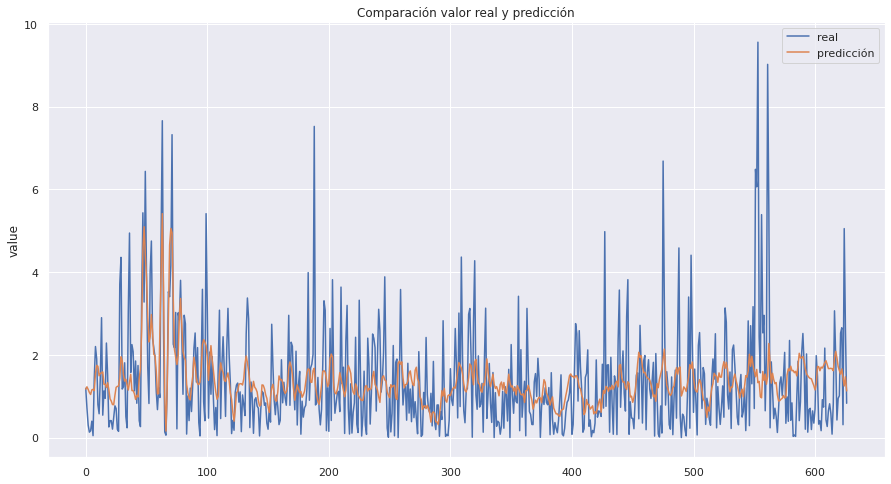

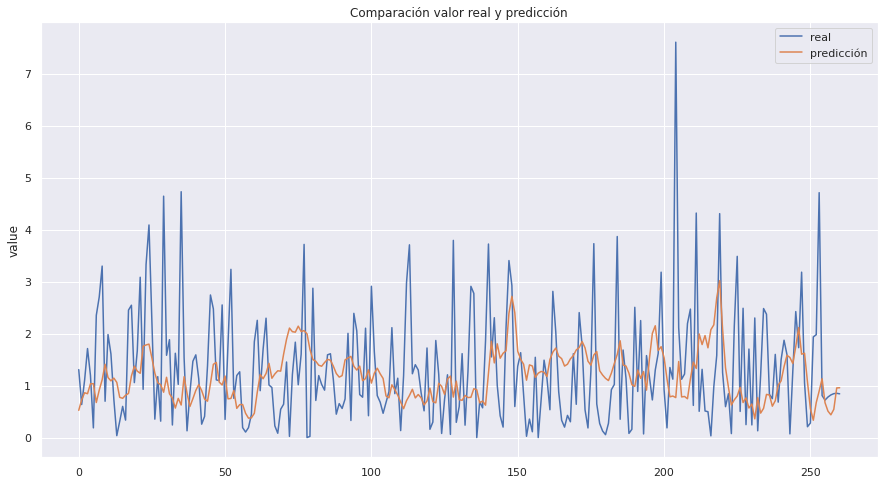

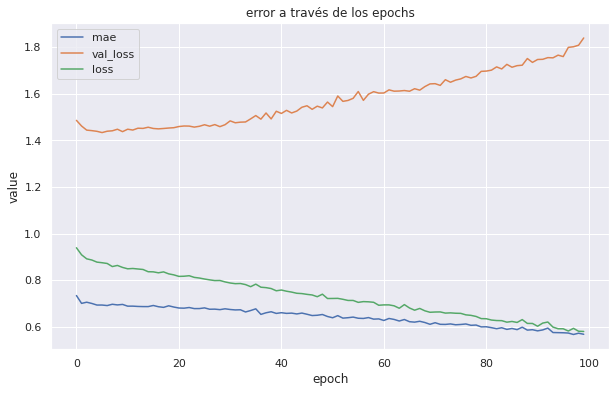

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.2748186599645466
MAE is : 0.78835669693457
RMSE is : 1.1290786774908765
MAPE is : 39.178905519870234
Evaluation metric results:
MSE is : 1.3649005299401178
MAE is : 0.856686306309025
RMSE is : 1.1682895745234216
MAPE is : 38.76303431262569
(627, 15, 4) (627, 1)
(261, 15, 4) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 56ms/step - loss: 0.9456 - mae: 0.7331 - val_loss: 1.4821 - val_mae: 0.8277
Epoch 2/100
32/32 [==============================] - 1s 35ms/step - loss: 0.9164 - mae: 0.7069 - val_loss: 1.4568 - val_mae: 0.7608
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 0.8909 - mae: 0.7063 - val_loss: 1.4285 - val_mae: 0.7684
Epoch 4/100
32/32 [==============================] - 1s 35ms/step - loss: 0.8889 - mae: 0.7011 - val_loss: 1.4271 - val_mae: 0.7806
Epoch 5/100
32/32 [==============================] - 1s 36ms/step - loss: 0.8760 - mae: 0.6944 - va

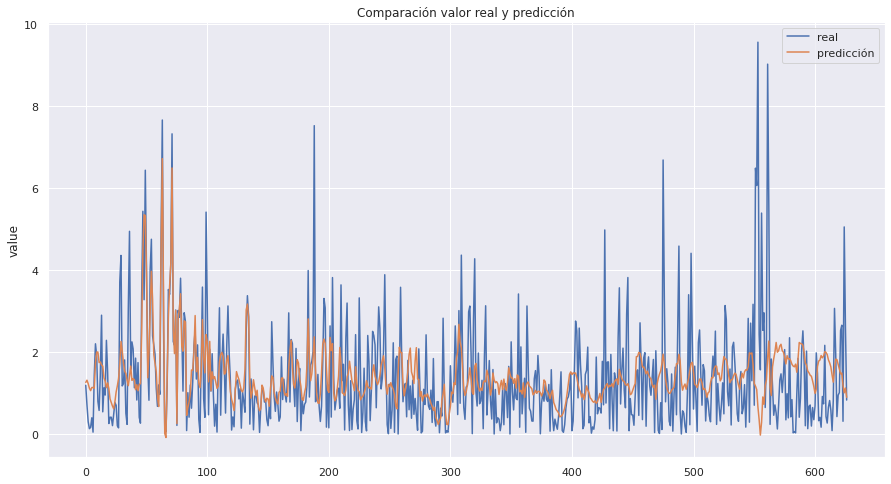

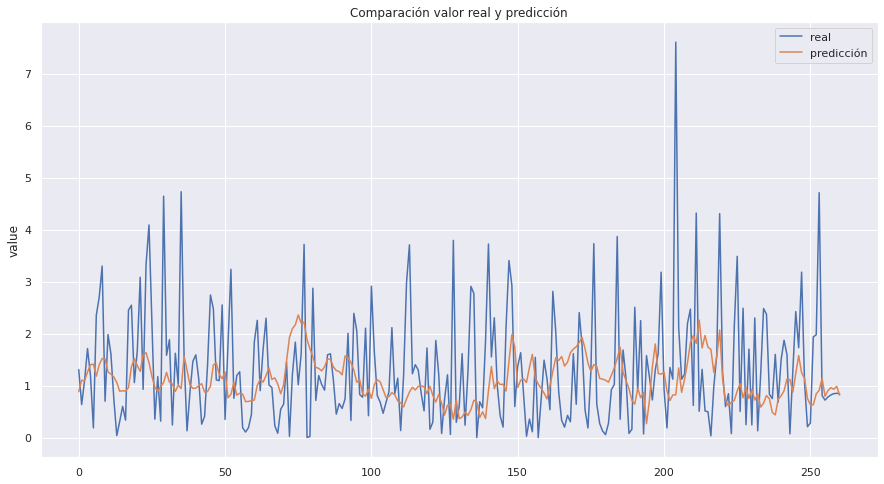

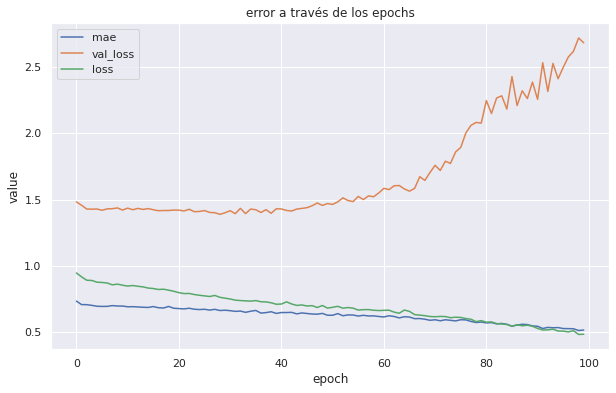

9/9 [==============================] - 0s 14ms/step
Evaluation metric results:
MSE is : 1.4133957928814163
MAE is : 0.7771010503094322
RMSE is : 1.1888632355664028
MAPE is : 39.51954228580654
Evaluation metric results:
MSE is : 1.5554115809323792
MAE is : 0.9501499684596474
RMSE is : 1.2471614093341643
MAPE is : 46.105071744864645
(627, 15, 4) (627, 1)
(261, 15, 4) (261, 1)
Epoch 1/100
32/32 [==============================] - 7s 117ms/step - loss: 0.9617 - mae: 0.7399 - val_loss: 1.4795 - val_mae: 0.8138
Epoch 2/100
32/32 [==============================] - 3s 92ms/step - loss: 0.9134 - mae: 0.7054 - val_loss: 1.4413 - val_mae: 0.7546
Epoch 3/100
32/32 [==============================] - 3s 91ms/step - loss: 0.8862 - mae: 0.7047 - val_loss: 1.4220 - val_mae: 0.7608
Epoch 4/100
32/32 [==============================] - 3s 92ms/step - loss: 0.8831 - mae: 0.7003 - val_loss: 1.4302 - val_mae: 0.7722
Epoch 5/100
32/32 [==============================] - 3s 91ms/step - loss: 0.8687 - mae: 0.6935

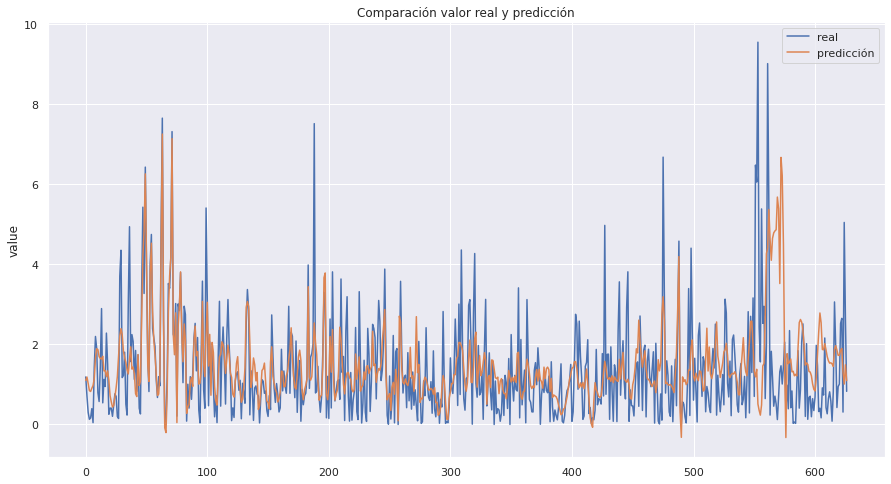

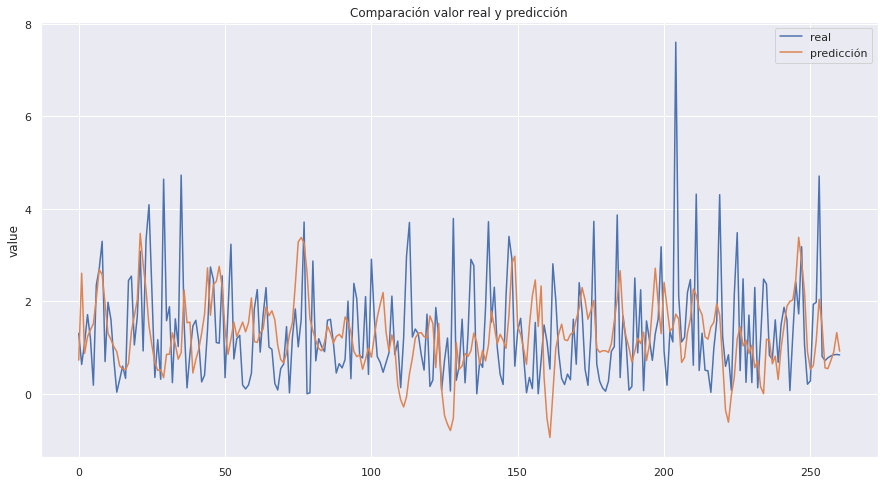

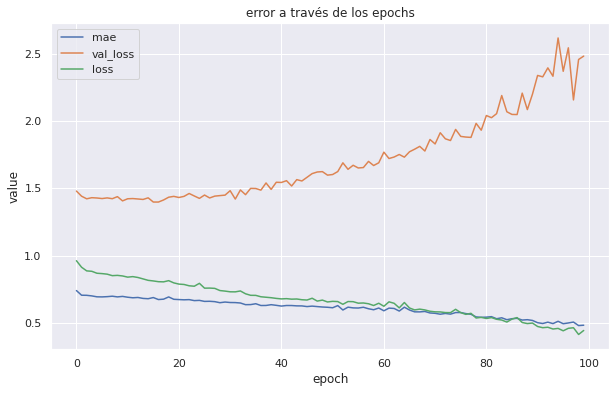

9/9 [==============================] - 0s 32ms/step
Evaluation metric results:
MSE is : 1.2450892270317733
MAE is : 0.7084384228379673
RMSE is : 1.1158356630937072
MAPE is : 34.58075756627776
Evaluation metric results:
MSE is : 1.5971717245032195
MAE is : 0.94381482127744
RMSE is : 1.263792595524764
MAPE is : 41.59321824797539


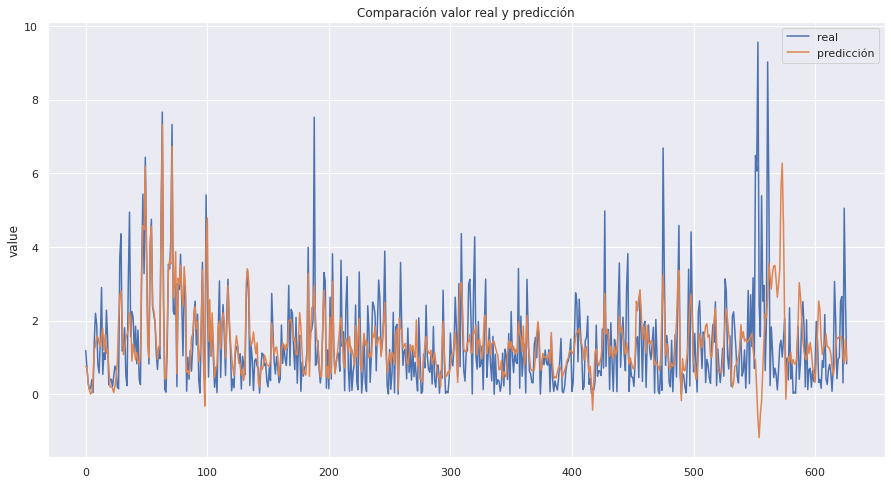

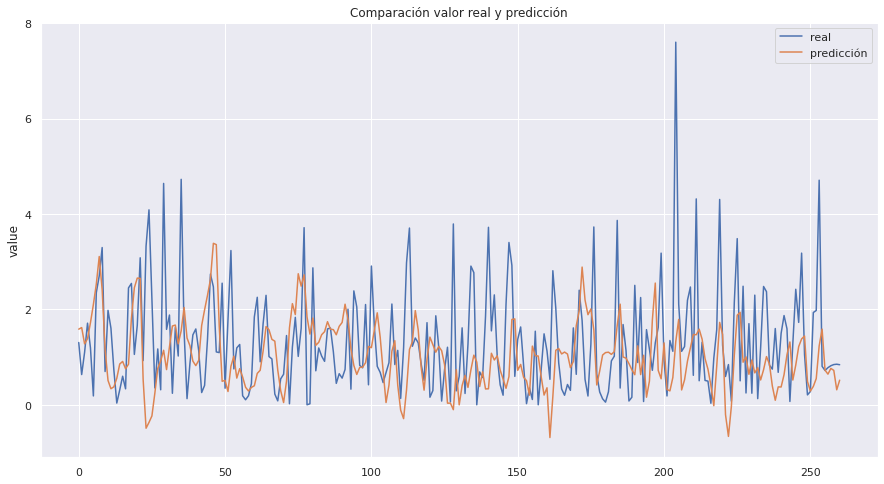

In [12]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=4,epochss=100,batch_sizze=16,lag=lg)